In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)#display all columns
from sklearn.preprocessing import StandardScaler
import pymssql
import pickle
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, auc, precision_recall_fscore_support
from sklearn.metrics import brier_score_loss

/Users/dykim/opt/anaconda3/envs/Cornell/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#connect with SQL server
connection = pymssql.connect(server='vits-archsqlp04.a.wcmc-ad.net', user=r'CUMC\id', password='pwd',database='FULL_OMOP')
cur = connection.cursor()

In [4]:
##############################################
##Pull data files from OMOP
##Save SQL output as CSV

In [5]:
path = './data_until_2020/'

In [26]:
#person

In [210]:
##retrieve all 'person_id's of pregnant patients without the data of patient self-reported and ehr problem list entry
##purpose: get person_ids of patients that are were pregnant


cur.execute('''
SELECT DISTINCT
	person_id INTO ##temp_persons
FROM
	full_omop.geo.condition_occurrence co
WHERE
	condition_concept_id in(40618896, 4242241, 4174506, 443871, 4290009, 433864, 4283690, 4007285, 432430, 4326232, 435640, 442355, 438543, 4337360, 438542, 439922, 441678, 4248725, 444067, 4195157, 4270513, 4217975, 444267, 4049621, 434484, 4313026, 4274955, 4218813, 444417, 4051642, 435655, 4336226, 444461, 4277749, 4097608, 443874, 4244438, 4181751, 444023, 4245908, 4185780, 442558, 4220085, 444098, 4266517, 4197245, 442769, 4239938, 4132434, 45542428, 45609932, 45571352, 45600326, 45609934, 45552081, 45585825, 45600327, 45600325, 45542425, 45542427, 45571351, 45609935, 45552082, 45585826, 45542426, 45571350, 45537634, 45605127, 45547308, 45609933, 45581026, 45537635, 45605128, 45537633, 45605126, 45605125, 45566426, 45595510, 45595511, 45595512, 45585827, 45556830, 45556831, 45590721, 45556832, 45595509)
	AND co.condition_type_concept_id != 45905770
	AND co.condition_type_concept_id != 38000245
	and(condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%');
''')

##40618896 Gestation period, 24 weeks
##4242241 Gestation period, 10 weeks
##4174506 Gestation period, 11 weeks
##443871 Gestation period, 38 weeks
##...

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry




In [30]:
##purpose: get information of patients

cur.execute('''
select * from full_omop.geo.person p
where person_id in (select * from ##temp_persons) ;
''')
person_sql = cur.fetchall()

In [31]:
##define person dataframe
person = pd.DataFrame(person_sql)
person.columns = ['person_id','gender_concept_id','year_of_birth','month_of_birth','day_of_birth','birth_datetime','race_concept_id',
       'ethnicity_concept_id','location_id','provider_id','care_site_id','person_source_value','gender_source_value',
       'gender_source_concept_id','race_source_value','race_source_concept_id','ethnicity_source_value','ethnicity_source_concept_id']

In [32]:
person.shape

(37024, 18)

In [15]:
person.to_csv(path + "person.csv", index=None)

In [14]:
#delivery

In [81]:
##retrieve data of patients who had a delivery without data of patient self-reported and EHR problem list entry
cur.execute('''
SELECT
	o.*, c.concept_name, pl.mrn
FROM
	full_omop.geo.condition_occurrence o
    JOIN full_omop.geo.concept c ON o.condition_concept_id = c.concept_id
	JOIN full_omop.geo.person_lookup pl ON o.person_id = pl.person_id
WHERE
	o.condition_type_concept_id != 45905770
	AND o.condition_type_concept_id != 38000245
	AND condition_concept_id in(441641, 4014295, 44784551, 44784550, 4086393, 4009589, 443445, 40394469, 40359641, 4038495, 4066112, 4061457, 4061458, 4154615, 40333701, 40311821, 4149449, 40398264, 46271955, 4129042, 4125611, 45757176, 45757175, 37016212)
	and (condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%');
'''
)
delivery_sql = cur.fetchall()
print('delivery done')

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry

##441641 Delivery normal
##4014295 Single live birth
##44784551 Preterm spontaneous labor with term delivery
##44784550 Preterm spontaneous labor with preterm delivery




delivery done


In [82]:
delivery = pd.DataFrame(delivery_sql)
delivery.columns = ['condition_occurrence_id', 'person_id', 'condition_concept_id', 'condition_start_date','condition_start_datetime', 
                    'condition_end_date', 'condition_end_datetime', 'condition_type_concept_id', 'stop_reason', 'provider_id', 
                    'visit_occurrence_id','visit_detail_id', 'condition_source_value', 'condition_source_concept_id','condition_status_source_value', 
                    'condition_status_concept_id', 'concept_name', 'mrn']

In [83]:
delivery.to_csv(path + "delivery.csv", index=None)

In [20]:
#stillbirth

In [227]:
##retrive data of stillbirth
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.condition_occurrence c2
	JOIN full_omop.geo.person_lookup pl ON c2.person_id = pl.person_id
	JOIN ##temp_persons ps on ps.person_id=c2.person_id
WHERE
	c2.condition_type_concept_id != 45905770
	AND c2.condition_type_concept_id != 38000245
	and(condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%')
	AND condition_concept_id in(
		SELECT
			concept_id FROM full_omop.geo.CONCEPT
		WHERE (concept_name LIKE '%stillbirth%'
			OR concept_name LIKE '%still birth%'
			OR concept_name LIKE '%stillborn%')
		AND domain_id = 'Condition');
    ''')
stillbirth_sql = cur.fetchall()
print('stillbirth done')

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry

stillbirth done


In [228]:
stillbirth = pd.DataFrame(stillbirth_sql)
stillbirth.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
                      'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
                      'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id','condition_status_source_value',
                      'condition_status_concept_id','person_id1','mrn','empi_id','person_id2']

##if you don't have 'mrn' remove 'mrn' from stillbirth.columns

In [37]:
stillbirth.to_csv(path + "stillbirth.csv", index=None)

In [20]:
#miscarriage

In [39]:
##retrive data who had records of misscarriage
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.condition_occurrence co
	JOIN ##temp_persons ps on ps.person_id=co.person_id
	JOIN full_omop.geo.visit_occurrence vo ON vo.visit_occurrence_id = co.visit_occurrence_id
WHERE
	condition_concept_id in(40318617, 40318618, 4146772, 4146774, 4146775, 4149423, 4170121, 76482, 43530979, 4067106, 4078393, 4224646, 4244408, 4285746, 4294259, 4321536, 193820, 194704, 195317, 195594, 196746, 432682, 432689, 434094, 434413, 435000, 435318, 436176, 436742, 437045, 437920, 437933, 440460, 441348, 441631, 4011615, 4033096)
	AND condition_type_concept_id != 45905770
	AND condition_type_concept_id != 38000245
	AND (condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%');
    ''')
miscarriage_sql = cur.fetchall()
print('miscarriage done')

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry

##40318617 Incomplete miscarriage
##40318618 Complete miscarriage
##4146772 Inevitable miscarriage complete


miscarriage done


In [40]:
miscarriage  = pd.DataFrame(miscarriage_sql)
miscarriage.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date', 'condition_start_datetime',
                       'condition_end_date','condition_end_datetime','condition_type_concept_id', 'stop_reason','provider_id',
                       'visit_occurrence_id','visit_detail_id','condition_source_value', 'condition_source_concept_id','condition_status_source_value',
                       'condition_status_concept_id', 'person_id1','visit_occurrence_id1', 'person_id2','visit_concept_id',
                       'visit_start_date','visit_start_datetime','visit_end_date', 'visit_end_datetime','visit_type_concept_id',
                       'provider_id1','care_site_id','visit_source_value', 'visit_source_concept_id','admitting_source_concept_id',
                       'admitting_source_value', 'discharge_to_concept_id','discharge_to_source_value','preceding_visit_occurrence_id']

In [41]:
miscarriage.to_csv(path + "miscarriage.csv", index=None)

In [42]:
#gestational week

In [43]:
#retrieve data with the information of gestational week
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.condition_occurrence co
    JOIN full_omop.geo.concept c ON co.condition_concept_id = c.concept_id
	JOIN full_omop.geo.person_lookup pl ON co.person_id = pl.person_id
WHERE
	condition_concept_id in(40618896, 4242241, 4174506, 443871, 4290009, 433864, 4283690, 4007285, 432430, 4326232, 435640, 442355, 438543, 4337360, 438542, 439922, 441678, 4248725, 444067, 4195157, 4270513, 4217975, 444267, 4049621, 434484, 4313026, 4274955, 4218813, 444417, 4051642, 435655, 4336226, 444461, 4277749, 4097608, 443874, 4244438, 4181751, 444023, 4245908, 4185780, 442558, 4220085, 444098, 4266517, 4197245, 442769, 4239938, 4132434, 45542428, 45609932, 45571352, 45600326, 45609934, 45552081, 45585825, 45600327, 45600325, 45542425, 45542427, 45571351, 45609935, 45552082, 45585826, 45542426, 45571350, 45537634, 45605127, 45547308, 45609933, 45581026, 45537635, 45605128, 45537633, 45605126, 45605125, 45566426, 45595510, 45595511, 45595512, 45585827, 45556830, 45556831, 45590721, 45556832, 45595509)
	AND co.condition_type_concept_id != 45905770
	AND co.condition_type_concept_id != 38000245
	and(condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%');
''')
gestationalweek_sql = cur.fetchall()
print('gestationalweek done')


##40618896 Gestation period, 24 weeks
##4242241 Gestation period, 10 weeks
##4174506 Gestation period, 11 weeks
##443871 Gestation period, 38 weeks
##...

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry


gestationalweek done


In [44]:
gestationalweek = pd.DataFrame(gestationalweek_sql)
gestationalweek.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date', 'condition_start_datetime',
                           'condition_end_date','condition_end_datetime', 'condition_type_concept_id','stop_reason','provider_id',
                           'visit_occurrence_id', 'visit_detail_id','condition_source_value','condition_source_concept_id', 'condition_status_source_value',
                           'condition_status_concept_id','concept_id', 'concept_name','domain_id','vocabulary_id',
                           'concept_class_id','standard_concept', 'concept_code','valid_start_date','valid_end_date',
                           'invalid_reason', 'person_id1','mrn','empi_id']

In [45]:
gestationalweek.to_csv(path + "gestationalweek.csv", index=None)

In [46]:
#ppd

In [47]:
##retrieve data of patients with depressive disorder
##for the data that condition_concept_id does not postpartum depression,
##calculated with delivery date afterwards,
##whether depression is within 1 year after the delivery or not

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.condition_occurrence c2
    JOIN full_omop.geo.concept con ON c2.condition_concept_id = con.concept_id
	JOIN full_omop.geo.person_lookup pl ON c2.person_id = pl.person_id
WHERE
	condition_concept_id in(45533100,45538065,45547705,45552478,45557202,45562041,45566845,45571759,45571760,45576542,45576543,45581458,45595904,45600740,1568217,1568218,1568219,1595539,35207150,35207151,35207152,35207154,35207155,35207156,35207157,35207158,35207160,35207161,35207163,45586238,35207164,45538066,35207165,45600741,45533101,45586239,45566842,35207166,45591137,37200320,45547704,45547706,45552479,45571761,45576541,44821821,44822975,44822976,44824114,44825293,44827654,44835784,44827656,44829923,44831089,44831090,44832232,44834589,44835784,44835785,44833406,44822983,432284,433750,433991,435220,436945,437837,440075,4025677,4093584,4098300,4098301,4100371,4102664,4102665,4103260,4103573,4126786,4129184,4129842,4141235,4148630,4149320,4149321,4151170,4152280,4154391,4174987,4176002,4181807,4197222,4205471,4220023,4223090,4226155,4239471,4263748,4269493,4270907,4282096,4282316,4287238,4298317,4304140,4307111,4323418,4324959,4327337,4336957,4338031,35609623,35610108,35610109,35615151,35615152,35615153,35615154,35615155,36712668,36713698,36714389,36714997,36714998,36714999,36715000,36717092,36717269,36717389,37016718,37018656,37109052,37109053,37109054,40311744,40321785,40321819,40322275,40322276,40322277,40322278,40322279,40356775,40385094,40385130,40388268,40389289,40560647,40608397,42534817,42872411,42872722,43021839,43531624,44782943,44788804,44805544,44805549,44805550,44805551,44806193,44813499,45757195,45757196,45757213,45538069,45581461,44826524,44832253,442306,4038252,4165411,4167727,36684319,36716734,40306911,40546087,40546698,44782518,44782706,45767313,44832235,44826525,44833421,44832235,44836972,44830224,44833726,44821029,44836085,35207208,45576552,1595539,45586246,45557212,45542856,45552496,45542849,45566845,45571763,45571764,45595908,45605492,1568230,35207170,35207171,35207172,35207173,45538069,45547707,44820725,44822995,44829926,44831093,44832239,44832253,434613,441542,442077,4085054,4098313,4098314,4102799,4103273,4113821,4214746,4263429,4322025,4338031,35615151,35615152,35615153,35615155,36684319,37109052,37109053,37109054,40321778,40322276,40356771,40385090,40385093,40385094,40388308,40549910,40620334,42538968,45757095)
	AND c2.condition_type_concept_id != 45905770
	AND c2.condition_type_concept_id != 38000245
	and(condition_start_date LIKE '2019%' or condition_start_date LIKE '2020%');
        ''')
ppd_sql = cur.fetchall()
print('ppd done')

##45533100 Recurrent depressive disorder, currently in remission
##45538065 Recurrent depressive disorder, current episode mild
##45547705 Recurrent depressive disorder, current episode severe without psychotic symptoms
##45552478 Moderate depressive episode
##1595539 Postpartum depression
##35207150 Major depressive disorder, single episode, mild
##...

##45905770 Patient Self-Reported Condition
##38000245 EHR problem list entry



ppd done


In [48]:
ppd = pd.DataFrame(ppd_sql)
ppd.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date', 'condition_start_datetime',
               'condition_end_date','condition_end_datetime','condition_type_concept_id', 'stop_reason','provider_id',
               'visit_occurrence_id','visit_detail_id','condition_source_value', 'condition_source_concept_id','condition_status_source_value',
               'condition_status_concept_id', 'concept_id','concept_name','domain_id','vocabulary_id',
               'concept_class_id','standard_concept', 'concept_code','valid_start_date','valid_end_date',
               'invalid_reason','person_id1','mrn','empi_id']

In [49]:
ppd.to_csv(path + "ppd.csv", index=None)

In [50]:
#medication

In [51]:
##ATC: Anatomical Therapeutic Chemical -> medicines that is maintained by WHO
##ATC antidepression code exists in 1 year after childbirth -> consider the patient has ppd
cur.execute('''
SELECT
	* INTO #concepts
FROM
	full_omop.geo.CONCEPT_ANCESTOR ca
	JOIN full_omop.geo.concept c2 ON c2.concept_id = ca.ancestor_concept_id
		AND c2.vocabulary_id = 'ATC';
''')

In [52]:
##retreive all the medicines that the pregnant patients used

cur.execute('''
SELECT distinct
	drug_exposure_id,
	de.person_id,
	cs.concept_class_id AS [concept_class_id.1],
	cs.concept_code AS [concept_code.1],
	cs.concept_name AS [concept_name.1],
	con.concept_name AS concept_name,
	drug_exposure_start_date,
	mrn
FROM
	full_omop.geo.drug_exposure de
	JOIN ##temp_persons ps on ps.person_id=de.person_id
	JOIN full_omop.geo.concept con ON con.concept_id = de.drug_concept_id
	JOIN full_omop.geo.person_lookup pl ON de.person_id = pl.person_id
	JOIN #concepts cs on cs.descendant_concept_id=de.drug_concept_id
		AND drug_type_concept_id IS NOT NULL
		AND stop_reason IS NULL
		and(drug_exposure_start_date LIKE '2019%'
			OR drug_exposure_start_date LIKE '2020%');
    ''')
medication_sql = cur.fetchall()
print('medication done')

medication done


In [53]:
medication = pd.DataFrame(medication_sql)
medication.columns = ['drug_exposure_id','person_id','concept_class_id.1','concept_code.1','concept_name.1',
                      'concept_name','drug_exposure_start_date','mrn']

In [54]:
medication.to_csv(path + "medication.csv", index=None)

In [55]:
#condition

In [56]:
##retrieve all the data of conditions that pregnant patient had

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.condition_occurrence c2
	JOIN ##temp_persons ps on ps.person_id=c2.person_id
    JOIN full_omop.geo.concept con ON c2.condition_concept_id = con.concept_id
	JOIN full_omop.geo.person_lookup pl ON c2.person_id = pl.person_id
WHERE
	c2.condition_type_concept_id != 45905770
	AND c2.condition_type_concept_id != 38000245
	and (condition_start_date LIKE '2019%'
		OR condition_start_date LIKE '2020%');
        ''')
condition_sql = cur.fetchall()
print('condition done')

condition done


In [57]:
condition = pd.DataFrame(condition_sql)
condition.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date', 'condition_start_datetime',
                     'condition_end_date','condition_end_datetime','condition_type_concept_id', 'stop_reason','provider_id',
                     'visit_occurrence_id','visit_detail_id','condition_source_value', 'condition_source_concept_id','condition_status_source_value',
                     'condition_status_concept_id','person_id1','concept_id','concept_name','domain_id','vocabulary_id',
                     'concept_class_id','standard_concept', 'concept_code','valid_start_date','valid_end_date',
                     'invalid_reason','person_id2','mrn', 'empi_id']

In [58]:
condition.to_csv(path + "condition.csv", index=None)

In [59]:
#BMI

In [60]:
##retrieve all the BMI data of pregnant patients

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.MEASUREMENT m
	JOIN full_omop.geo.concept c ON m.measurement_concept_id = c.concept_id
	JOIN ##temp_persons ps on ps.person_id=m.person_id
WHERE (concept_name LIKE '%BMI%'
	OR concept_name LIKE '%Body mass index%')
and(measurement_date LIKE '2019%'
	OR measurement_date LIKE '2020%');
    ''')
bmi_sql = cur.fetchall()
print('bmi done')

bmi done


In [61]:
bmi = pd.DataFrame(bmi_sql)
bmi.columns =  ['measurement_id','person_id','measurement_concept_id','measurement_date', 'measurement_datetime',
                'measurement_type_concept_id','operator_concept_id', 'value_as_number','value_as_concept_id','unit_concept_id',
                'range_low','range_high', 'provider_id','visit_occurrence_id','visit_detail_id',
                'measurement_source_value', 'measurement_source_concept_id','unit_source_value','value_source_value','concept_id', 
                'concept_name','domain_id','vocabulary_id','concept_class_id','standard_concept', 
                'concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']

In [62]:
bmi.to_csv(path + "bmi.csv", index=None)

In [45]:
#blood pressure

In [63]:
##retrieve all the bp data of pregnant patients
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.MEASUREMENT m
	JOIN full_omop.geo.concept c ON m.measurement_concept_id = c.concept_id
	JOIN ##temp_persons ps on ps.person_id=m.person_id
WHERE (concept_name LIKE '%systolic bp%'
	OR concept_name LIKE '%diastolic bp%'
	OR concept_name LIKE '%systolic blood pressure%'
	OR concept_name LIKE '%diastolic blood pressure%')
and(measurement_date LIKE '2019%'
	OR measurement_date LIKE '2020%');
''')
bp_sql = cur.fetchall()
print('bp done')

bp done


In [64]:
bp = pd.DataFrame(bp_sql)
bp.columns = ['measurement_id','person_id','measurement_concept_id','measurement_date','measurement_datetime',
                      'measurement_type_concept_id','operator_concept_id','value_as_number','value_as_concept_id','unit_concept_id',
                      'range_low','range_high','provider_id','visit_occurrence_id','visit_detail_id',
                      'measurement_source_value','measurement_source_concept_id','unit_source_value','value_source_value','concept_id',
                      'concept_name','domain_id','vocabulary_id','concept_class_id','standard_concept',
                      'concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']

In [65]:
bp.to_csv(path + "bp.csv", index=None)

In [66]:
#weight

In [8]:
##retrieve all the weight data of pregnant patients

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.MEASUREMENT m
	JOIN full_omop.geo.concept c ON m.measurement_concept_id = c.concept_id
	JOIN ##temp_persons ps on ps.person_id=m.person_id
WHERE (concept_name LIKE '%body weight%'
	OR measurement_source_value LIKE '%Weight%')
and(measurement_date LIKE '2019%'
	OR measurement_date LIKE '2020%');
''')
weight_sql = cur.fetchall()
print('weight done')

weight done


In [9]:
weight = pd.DataFrame(weight_sql)
weight.columns = ['measurement_id','person_id','measurement_concept_id','measurement_date', 'measurement_datetime',
                  'measurement_type_concept_id','operator_concept_id', 'value_as_number','value_as_concept_id','unit_concept_id',
                  'range_low','range_high', 'provider_id','visit_occurrence_id','visit_detail_id',
                  'measurement_source_value', 'measurement_source_concept_id','unit_source_value','value_source_value','concept_id', 
                  'concept_name','domain_id','vocabulary_id','concept_class_id','standard_concept', 
                  'concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']

In [10]:
weight.to_csv(path + "weight.csv", index=None)

In [11]:
#amniocentesis

In [12]:
##retrieve all the data of pregnant patients who recieved amniocentesis

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.PROCEDURE_OCCURRENCE po
	JOIN full_omop.geo.concept con ON po.PROCEDURE_concept_id = con.concept_id
	JOIN ##temp_persons ps on ps.person_id=po.person_id
WHERE
	concept_name LIKE '%amniocentesis%'
	and (procedure_date LIKE '2019%'
		OR procedure_date LIKE '2020%');
        ''')
amniocentesis_sql = cur.fetchall()
print('amniocentesis done')

amniocentesis done


In [13]:
amniocentesis = pd.DataFrame(amniocentesis_sql)
amniocentesis.columns = ['procedure_occurrence_id','person_id','procedure_concept_id','procedure_date', 'procedure_datetime',
                         'procedure_type_concept_id','modifier_concept_id','quantity', 'provider_id','visit_occurrence_id',
                         'visit_detail_id','procedure_source_value', 'procedure_source_concept_id','modifier_source_value','concept_id',
                         'concept_name', 'domain_id','vocabulary_id','concept_class_id','standard_concept',
                         'concept_code', 'valid_start_date','valid_end_date','invalid_reason','person_id1']

In [14]:
amniocentesis.to_csv(path + "amniocentesis.csv", index=None)

In [15]:
#Marital: married

In [16]:
##retrieve marraige status data of patients who had a delivery of baby

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.note n
	JOIN full_omop.geo.person_lookup pl ON pl.person_id = n.person_id
WHERE (note_text LIKE '%Marital Status Married%'
	OR note_text LIKE '%Marital Status: Married%'
	OR note_text LIKE '%Marital Status:Married%')
AND n.person_id in( SELECT DISTINCT
		o.person_id FROM full_omop.geo.condition_occurrence o
		JOIN full_omop.geo.concept c ON o.condition_concept_id = c.concept_id
		JOIN full_omop.geo.person_lookup pl ON o.person_id = pl.person_id
	WHERE
		o.condition_type_concept_id != 45905770
		AND o.condition_type_concept_id != 38000245
		AND concept_id in(441641, 4014295, 44784551, 44784550, 4086393, 4009589, 443445, 40394469, 40359641, 4038495, 4066112, 4061457, 4061458, 4154615, 40333701, 40311821, 4149449, 40398264, 46271955, 4129042, 4125611, 45757176, 45757175, 37016212)
		and(o.condition_start_date LIKE '2019%'
			OR o.condition_start_date LIKE '2020%'));
''')
married_sql = cur.fetchall()
print('married done')


##441641 Delivery normal
##4014295 Single live birth
##4066112 Delivery by emergency cesarean section
##45757175 Preterm labor in second trimester with preterm delivery in second trimester
##37016212 Baby premature 34 weeks
##4009589 Post-term delivery





married done


In [17]:
married = pd.DataFrame(married_sql)
married.columns = ['note_id','person_id','note_date','note_datetime','note_type_concept_id', 
                   'note_class_concept_id','note_title','note_text','encoding_concept_id', 'language_concept_id',
                   'provider_id','visit_occurrence_id','visit_detail_id', 'note_source_value','person_id1',
                   'mrn','empi_id']

In [18]:
married.to_csv(path + "married.csv", index=None)

In [19]:
#Marital: single

In [20]:
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.note n
	JOIN full_omop.geo.person_lookup pl ON pl.person_id = n.person_id
WHERE (note_text LIKE '%Marital Status single%'
	OR note_text LIKE '%Marital Status: single%'
	OR note_text LIKE '%Marital Status:single%')
AND n.person_id in( SELECT DISTINCT
		o.person_id FROM full_omop.geo.condition_occurrence o
		JOIN full_omop.geo.concept c ON o.condition_concept_id = c.concept_id
		JOIN full_omop.geo.person_lookup pl ON o.person_id = pl.person_id
	WHERE
		o.condition_type_concept_id != 45905770
		AND o.condition_type_concept_id != 38000245
		AND concept_id in(441641, 4014295, 44784551, 44784550, 4086393, 4009589, 443445, 40394469, 40359641, 4038495, 4066112, 4061457, 4061458, 4154615, 40333701, 40311821, 4149449, 40398264, 46271955, 4129042, 4125611, 45757176, 45757175, 37016212)
		and(o.condition_start_date LIKE '2019%'
			OR o.condition_start_date LIKE '2020%'));
''')
single_sql = cur.fetchall()
print('single done')


##441641 Delivery normal
##4014295 Single live birth
##4066112 Delivery by emergency cesarean section
##45757175 Preterm labor in second trimester with preterm delivery in second trimester
##37016212 Baby premature 34 weeks
##4009589 Post-term delivery





single done


In [21]:
single = pd.DataFrame(single_sql)
single.columns = ['note_id','person_id','note_date','note_datetime','note_type_concept_id', 
                   'note_class_concept_id','note_title','note_text','encoding_concept_id', 'language_concept_id',
                   'provider_id','visit_occurrence_id','visit_detail_id', 'note_source_value','person_id1',
                   'mrn','empi_id']

In [22]:
single.to_csv(path + "single.csv", index=None)

In [23]:
#Marital: widowed

In [24]:
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.note n
	JOIN full_omop.geo.person_lookup pl ON pl.person_id = n.person_id
WHERE (note_text LIKE '%Marital Status WIDOWED%'
	OR note_text LIKE '%Marital Status: WIDOWED%'
	OR note_text LIKE '%Marital Status:WIDOWED%')
AND n.person_id in( SELECT DISTINCT
		o.person_id FROM full_omop.geo.condition_occurrence o
		JOIN full_omop.geo.concept c ON o.condition_concept_id = c.concept_id
		JOIN full_omop.geo.person_lookup pl ON o.person_id = pl.person_id
	WHERE
		o.condition_type_concept_id != 45905770
		AND o.condition_type_concept_id != 38000245
		AND concept_id in(441641, 4014295, 44784551, 44784550, 4086393, 4009589, 443445, 40394469, 40359641, 4038495, 4066112, 4061457, 4061458, 4154615, 40333701, 40311821, 4149449, 40398264, 46271955, 4129042, 4125611, 45757176, 45757175, 37016212)
		and(o.condition_start_date LIKE '2019%'
			OR o.condition_start_date LIKE '2020%'));
            ''')
widowed_sql = cur.fetchall()
print('widowed done')

##441641 Delivery normal
##4014295 Single live birth
##4066112 Delivery by emergency cesarean section
##45757175 Preterm labor in second trimester with preterm delivery in second trimester
##37016212 Baby premature 34 weeks
##4009589 Post-term delivery




widowed done


In [25]:
widowed = pd.DataFrame(widowed_sql)
widowed.columns = ['note_id','person_id','note_date','note_datetime','note_type_concept_id', 
                   'note_class_concept_id','note_title','note_text','encoding_concept_id', 'language_concept_id',
                   'provider_id','visit_occurrence_id','visit_detail_id', 'note_source_value','person_id1',
                   'mrn','empi_id']

In [26]:
widowed.to_csv(path + "widowed.csv", index=None)

In [27]:
#Marital: divorced

In [28]:
cur.execute('''
SELECT
	*
FROM
	full_omop.geo.note n
	JOIN full_omop.geo.person_lookup pl ON pl.person_id = n.person_id
WHERE (note_text LIKE '%Marital Status DIVORCED%'
	OR note_text LIKE '%Marital Status: DIVORCED%'
	OR note_text LIKE '%Marital Status:DIVORCED%')
AND n.person_id in( SELECT DISTINCT
		o.person_id FROM full_omop.geo.condition_occurrence o
		JOIN full_omop.geo.concept c ON o.condition_concept_id = c.concept_id
		JOIN full_omop.geo.person_lookup pl ON o.person_id = pl.person_id
	WHERE
		o.condition_type_concept_id != 45905770
		AND o.condition_type_concept_id != 38000245
		AND concept_id in(441641, 4014295, 44784551, 44784550, 4086393, 4009589, 443445, 40394469, 40359641, 4038495, 4066112, 4061457, 4061458, 4154615, 40333701, 40311821, 4149449, 40398264, 46271955, 4129042, 4125611, 45757176, 45757175, 37016212)
		and(o.condition_start_date LIKE '2019%'
			OR o.condition_start_date LIKE '2020%'));
            ''')
divorced_sql = cur.fetchall()
print('divorced done')

##441641 Delivery normal
##4014295 Single live birth
##4066112 Delivery by emergency cesarean section
##45757175 Preterm labor in second trimester with preterm delivery in second trimester
##37016212 Baby premature 34 weeks
##4009589 Post-term delivery






divorced done


In [29]:
divorced = pd.DataFrame(divorced_sql)
divorced.columns = ['note_id','person_id','note_date','note_datetime','note_type_concept_id', 
                   'note_class_concept_id','note_title','note_text','encoding_concept_id', 'language_concept_id',
                   'provider_id','visit_occurrence_id','visit_detail_id', 'note_source_value','person_id1',
                   'mrn','empi_id']

In [30]:
divorced.to_csv(path + "divorced.csv", index=None)

In [31]:
#visit

In [8]:
##retrieve data of visit in 2019 and 2020 among targeted patients

cur.execute('''
SELECT
	*
FROM
	full_omop.geo.visit_occurrence vo
	JOIN full_omop.geo.person_lookup pl ON vo.person_id = pl.person_id
	JOIN ##temp_persons ps on ps.person_id=vo.person_id
		and(visit_start_date LIKE '2019%'
			OR visit_start_date LIKE '2020%');
''')
visit_sql = cur.fetchall()
print('visit done')

visit done


In [9]:
visit_orig = pd.DataFrame(visit_sql)
visit_orig.columns = ['visit_occurrence_id','person_id','visit_concept_id','visit_start_date','visit_start_datetime',
                 'visit_end_date','visit_end_datetime','visit_type_concept_id','provider_id','care_site_id',
                 'visit_source_value','visit_source_concept_id','admitting_source_concept_id','admitting_source_value','discharge_to_concept_id',
                 'discharge_to_source_value','preceding_visit_occurrence_id','person_id1','mrn','empi_id','person_id2']

In [10]:
visit_orig.to_csv(path + "visit.csv", index=None)

In [11]:
#meantal health: anxiety

In [12]:
#cur.execute('drop table ##temp_person_mental;')

In [13]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F40 refers to Phobic anxiety disorder
##concept_code = F41 refers to Other anxiety disorder
##concept_code = F42 refers to Obsessive-compulsive disorder
##...

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 300.0 refers to Anxiety states
##concept_code = 309.8 refers to Other specified adjustment reactions
##...

cur.execute('''
select distinct o.person_id  
into ##temp_person_mental  
from full_omop.geo.condition_occurrence o
join full_omop.geo.person_lookup pl on o.person_id=pl.person_id
where o.condition_type_concept_id != 45905770 and o.condition_type_concept_id !=38000245
and condition_concept_id in (441641,4014295,44784551,44784550,4086393,4009589,443445,40394469,40359641,4038495,4066112,4061457,4061458,4154615,40333701,40311821,4149449,40398264,46271955,4129042,4125611,45757176,45757175,37016212) 
/*and (o.condition_start_date like '2019%' or o.condition_start_date like '2020%')*/;

select cr.concept_id_2   
into #concepts_anxiety  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1
join FULL_OMOP.geo.concept c2 on c2.concept_id = cr.concept_id_2
where
(((c.concept_code like 'F40%' or c.concept_code like 'F41%' or c.concept_code like 'F42%' or c.concept_code like 'F93.0%' or c.concept_code like 'F93.1%' or c.concept_code like 'F93.2%' or c.concept_code like 'F43.0%' or c.concept_code like 'F43.1%' or c.concept_code like 'F43.8%' or c.concept_code like 'F43.9%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '300.0%' or c.concept_code like '300.2%' or c.concept_code like '300.3%' or c.concept_code like '309.8%' or c.concept_code like '308.3%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

select *
from FULL_OMOP.geo.condition_occurrence co
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join full_omop.geo.person_lookup pl on pl.person_id=co.person_id  
join #concepts_anxiety ca on ca.concept_id_2 = c.concept_id  
join ##temp_person_mental pm on pm.person_id = co.person_id;
''')
anxiety_sql = cur.fetchall()
print('anxiety done')

anxiety done


In [14]:
anxiety = pd.DataFrame(anxiety_sql)
anxiety = anxiety.iloc[:,0:27]
anxiety.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id',
'condition_status_source_value','condition_status_concept_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']
anxiety.to_csv(path + "anxiety.csv", index=None)

In [15]:
#meantal health: mood disorder

In [16]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F30 refers to Manic episode
##concept_code = F31 refers to Bipolar disorder
##concept_code = F34 refers to Persistent mood [affective] disorders
##...

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 296.0 refers to Bipolar I disorder, single manic episode
##concept_code = 296.1 refers to Manic disorder, recurrent episode
##...

cur.execute('''
select cr.concept_id_2  
into #concepts_mooddisorder  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1
join FULL_OMOP.geo.concept c2 on c2.concept_id = cr.concept_id_2
where
(((c.concept_code like 'F30%' or c.concept_code like 'F31%' or c.concept_code like 'F34.0%' or c.concept_code like 'F32%' or c.concept_code like 'F33%' or c.concept_code like 'F34.1%' or c.concept_code like 'F38.1%' or c.concept_code like 'F34.8%' or c.concept_code like 'F34.9%' or c.concept_code like 'F38.0%' or c.concept_code like 'F38.8%' or c.concept_code like 'F39%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '296.0%' or c.concept_code like '296.1%' or c.concept_code like '296.4%' or c.concept_code like '296.8%' or c.concept_code like '296.5%' or c.concept_code like '296.6%' or c.concept_code like '296.7%' or c.concept_code like '296.2%' or c.concept_code like '296.3%' or c.concept_code like '300.4%' or c.concept_code like '311%' or c.concept_code like '296.9%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

select *
from FULL_OMOP.geo.condition_occurrence co
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join full_omop.geo.person_lookup pl on pl.person_id=co.person_id  
join #concepts_mooddisorder cm on cm.concept_id_2 = c.concept_id  
join ##temp_person_mental pm on pm.person_id = co.person_id;
''')
mooddisorder_sql = cur.fetchall()
print('mooddisorder done')

mooddisorder done


In [17]:
mooddisorder = pd.DataFrame(mooddisorder_sql)
mooddisorder = mooddisorder.iloc[:,0:27]
mooddisorder.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id',
'condition_status_source_value','condition_status_concept_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']
mooddisorder.to_csv(path + "mooddisorder.csv", index=None)

In [18]:
#meantal health: organic disorder

In [19]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F00 refers to Dementia in Alzheimer disease
##concept_code = F01 refers to Vascular dementia

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 290.0 refers to Senile dementia, uncomplicated
##concept_code = 290.1 refers to Presenile dementia
##...


cur.execute('''
select cr.concept_id_2  
into #concepts_organicdisorder  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1
join FULL_OMOP.geo.concept c2 on c2.concept_id = cr.concept_id_2
where
(((c.concept_code like 'F00%' or c.concept_code like 'F01%' or c.concept_code like 'F02%' or c.concept_code like 'F03%' or c.concept_code like 'F04%' or c.concept_code like 'F05%' or c.concept_code like 'F06%' or c.concept_code like 'F07%' or c.concept_code like 'F08%' or c.concept_code like 'F09%' or c.concept_code like 'G30%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '290.0%' or c.concept_code like '290.1%' or c.concept_code like '290.2%' or c.concept_code like '290.3%' or c.concept_code like '290.4%' or c.concept_code like '290.5%' or c.concept_code like '290.6%' or c.concept_code like '290.7%' or c.concept_code like '290.8%' or c.concept_code like '290.9%' or c.concept_code like '293.0%' or c.concept_code like '293.1%' or c.concept_code like '293.8%' or c.concept_code like '293.9%' or c.concept_code like '294.0%' or c.concept_code like '294.1%' or c.concept_code like '294.8%' or c.concept_code like '294.9%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

select *
from FULL_OMOP.geo.condition_occurrence co
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join full_omop.geo.person_lookup pl on pl.person_id=co.person_id  
join #concepts_organicdisorder cod on cod.concept_id_2 = c.concept_id  
join ##temp_person_mental pm on pm.person_id = co.person_id;
''')
organicdisorder_sql = cur.fetchall()
print('organicdisorder done')

organicdisorder done


In [20]:
organicdisorder = pd.DataFrame(organicdisorder_sql)
organicdisorder = organicdisorder.iloc[:,0:27]
organicdisorder.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id',
'condition_status_source_value','condition_status_concept_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']
organicdisorder.to_csv(path + "organicdisorder.csv", index=None)

In [21]:
#mental health: other disorder

In [22]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F43 refers to Reaction to severe stress, and adjustment disorders
##concept_code = F99 refers to Mental disorder, not otherwise specified

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 309.0 refers to Adjustment disorder with depressed mood
##concept_code = 309.1 refers to Prolonged depressive reaction
##...


cur.execute('''
select cr.concept_id_2   
into #concepts_otherdisorder  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1
join FULL_OMOP.geo.concept c2 on c2.concept_id = cr.concept_id_2
where
(((c.concept_code like 'F43.2%' or c.concept_code like 'F99%' or c.concept_code like 'F52%' or c.concept_code like 'F64%' or c.concept_code like 'F65%' or c.concept_code like 'F66%' or c.concept_code like 'F63%' or c.concept_code like 'F91%' or c.concept_code like 'F92%' or c.concept_code like 'F95%' or c.concept_code like 'F44%' or c.concept_code like 'F48%' or c.concept_code like 'F50%' or c.concept_code like 'F51%' or c.concept_code like 'F53%' or c.concept_code like 'F54%' or c.concept_code like 'F68%' or c.concept_code like 'F70%' or c.concept_code like 'F71%' or c.concept_code like 'F72%' or c.concept_code like 'F73%' or c.concept_code like 'F84%' or c.concept_code like 'F98%' or c.concept_code like 'F79%' or c.concept_code like 'F78%' or c.concept_code like 'F80%' or c.concept_code like 'F81%' or c.concept_code like 'F82%' or c.concept_code like 'F83%' or c.concept_code like 'F88%' or c.concept_code like 'F89%' or c.concept_code like 'F90%' or c.concept_code like 'F93.3%' or c.concept_code like 'F93.4%' or c.concept_code like 'F93.5%' or c.concept_code like 'F93.6%' or c.concept_code like 'F93.7%' or c.concept_code like 'F93.8%' or c.concept_code like 'F93.9%' or c.concept_code like 'F94') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '309.0%' or c.concept_code like '309.1%' or c.concept_code like '309.2%' or c.concept_code like '309.3%' or c.concept_code like '309.4%' or c.concept_code like '309.8%' or c.concept_code like '309.9%' or c.concept_code like '302.0%' or c.concept_code like '302.1%' or c.concept_code like '302.2%' or c.concept_code like '302.3%' or c.concept_code like '302.4%' or c.concept_code like '302.5%' or c.concept_code like '302.6%' or c.concept_code like '302.7%' or c.concept_code like '302.8%' or c.concept_code like '302.9%' or c.concept_code like '297.0%' or c.concept_code like '297.1%' or c.concept_code like '297.2%' or c.concept_code like '297.3%' or c.concept_code like '297.8%' or c.concept_code like '297.9%' or c.concept_code like '312.0%' or c.concept_code like '312.1%' or c.concept_code like '312.2%' or c.concept_code like '312.3%' or c.concept_code like '312.4%' or c.concept_code like '312.8%' or c.concept_code like '312.9%' or c.concept_code like '298.0%' or c.concept_code like '298.1%' or c.concept_code like '298.2%' or c.concept_code like '298.3%' or c.concept_code like '298.4%' or c.concept_code like '299.0%' or c.concept_code like '299.1%' or c.concept_code like '299.8%' or c.concept_code like '299.9%' or c.concept_code like '300.1%' or c.concept_code like '300.5%' or c.concept_code like '300.6%' or c.concept_code like '300.7%' or c.concept_code like '300.8%' or c.concept_code like '300.9%' or c.concept_code like '307.0%' or c.concept_code like '307.1%' or c.concept_code like '307.2%' or c.concept_code like '307.3%' or c.concept_code like '307.4%' or c.concept_code like '307.5%' or c.concept_code like '307.6%' or c.concept_code like '307.7%' or c.concept_code like '307.9%' or c.concept_code like '308.0%' or c.concept_code like '308.1%' or c.concept_code like '308.2%' or c.concept_code like '308.9%' or c.concept_code like '310%' or c.concept_code like '313.0%' or c.concept_code like '313.1%' or c.concept_code like '313.2%' or c.concept_code like '313.3%' or c.concept_code like '313.8%' or c.concept_code like '313.9%' or c.concept_code like '314.0%' or c.concept_code like '314.1%' or c.concept_code like '314.2%' or c.concept_code like '314.8%' or c.concept_code like '314.9%' or c.concept_code like '315.0%' or c.concept_code like '315.1%' or c.concept_code like '315.2%' or c.concept_code like '315.3%' or c.concept_code like '315.4%' or c.concept_code like '315.5%' or c.concept_code like '315.9%' or c.concept_code like '316%' or c.concept_code like '317%' or c.concept_code like '318.0%' or c.concept_code like '318.1%' or c.concept_code like '318.2%' or c.concept_code like '319%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

select *
from FULL_OMOP.geo.condition_occurrence co
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join full_omop.geo.person_lookup pl on pl.person_id=co.person_id  
join #concepts_otherdisorder cod on cod.concept_id_2 = c.concept_id  
join ##temp_person_mental pm on pm.person_id = co.person_id;
''')
otherdisorder_sql = cur.fetchall()
print('otherdisorder done')

otherdisorder done


In [23]:
otherdisorder = pd.DataFrame(otherdisorder_sql)
otherdisorder = otherdisorder.iloc[:,0:27]
otherdisorder.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id',
'condition_status_source_value','condition_status_concept_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']
otherdisorder.to_csv(path + "otherdisorder.csv", index=None)

In [24]:
#mental health: personality disorder

In [25]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F60 refers to Specific personality disorders
##concept_code = F61 refers to Mixed and other personality disorders

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 301.0 refers to Paranoid personality disorder
##concept_code = 301.1 refers to Affective personality disorder
##...

cur.execute('''
select cr.concept_id_2   
into #concepts_personalitydisorder  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr 
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1 
where
(((c.concept_code like 'F60%' or c.concept_code like 'F61%' or c.concept_code like 'F62%' or c.concept_code like 'F69%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '301.0%' or c.concept_code like '301.1%' or c.concept_code like '301.2%' or c.concept_code like '301.3%' or c.concept_code like '301.4%' or c.concept_code like '301.5%' or c.concept_code like '301.6%' or c.concept_code like '301.7%' or c.concept_code like '301.8%' or c.concept_code like '301.9%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

SELECT
	*
FROM
	FULL_OMOP.geo.condition_occurrence co
	INNER JOIN full_omop.geo.visit_occurrence v ON co.visit_occurrence_id = v.visit_occurrence_id
	INNER JOIN FULL_OMOP.geo.concept c2 ON c2.concept_id = v.visit_concept_id
	JOIN FULL_OMOP.geo.concept c ON c.concept_id = co.condition_concept_id
	JOIN #concepts_personalitydisorder cpd on cpd.concept_id_2 = c.concept_id
/*WHERE (condition_start_date LIKE '2012%'
	OR condition_start_date LIKE '2013%'
	OR condition_start_date LIKE '2014%'
	OR condition_start_date LIKE '2015%'
	OR condition_start_date LIKE '2016%'
	OR condition_start_date LIKE '2017%'
	OR condition_start_date LIKE '2018%'
	OR condition_start_date LIKE '2019%'
	OR condition_start_date LIKE '2020%')*/;
      ''')
personalitydisorder_sql = cur.fetchall()
print('personalitydisorder')

personalitydisorder


In [26]:
personalitydisorder = pd.DataFrame(personalitydisorder_sql)
personalitydisorder.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id','visit_occurrence_id',
'visit_detail_id','condition_source_value','condition_source_concept_id','condition_status_source_value',
'condition_status_concept_id','visit_occurrence_id','person_id1','visit_concept_id','visit_start_date',
'visit_start_datetime','visit_end_date','visit_end_datetime','visit_type_concept_id','provider_id','care_site_id',
'visit_source_value','visit_source_concept_id','admitting_source_concept_id','admitting_source_value','discharge_to_concept_id',
'discharge_to_source_value','preceding_visit_occurrence_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','concept_id',
'concept_name','domain_id','vocabulary_id','concept_class_id','standard_concept','concept_code','valid_start_date',
'valid_end_date','invalid_reason','concept_id_2']
personalitydisorder.to_csv(path + "personalitydisorder.csv", index=None)

In [27]:
#mental health: schizophrenic

In [28]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F20 refers to Schizophrenia
##concept_code = F21 refers to Schizotypal disorder

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 295.0 refers to Simple type schizophrenia
##concept_code = 295.1 refers to Disorganized type schizophrenia
##...


cur.execute('''
select cr.concept_id_2   
into #concepts_schizophrenic  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr 
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1 
where
(((c.concept_code like 'F20%' or c.concept_code like 'F21%' or c.concept_code like 'F22%' or c.concept_code like 'F23%' or c.concept_code like 'F24%' or c.concept_code like 'F25%' or c.concept_code like 'F26%' or c.concept_code like 'F27%' or c.concept_code like 'F28%' or c.concept_code like 'F29%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '295.0%' or c.concept_code like '295.1%' or c.concept_code like '295.2%' or c.concept_code like '295.3%' or c.concept_code like '295.4%' or c.concept_code like '295.5%' or c.concept_code like '295.6%' or c.concept_code like '295.7%' or c.concept_code like '295.8%' or c.concept_code like '295.9%' or c.concept_code like '298.8%' or c.concept_code like '298.9%' or c.concept_code like '297.1%' or c.concept_code like '297.2%' or c.concept_code like '297.3%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';

select *
from FULL_OMOP.geo.condition_occurrence co
inner join full_omop.geo.visit_occurrence v on co.visit_occurrence_id=v.visit_occurrence_id
inner join FULL_OMOP.geo.concept c2 on c2.concept_id=v.visit_concept_id
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join #concepts_schizophrenic cs on cs.concept_id_2 = c.concept_id
/*where (condition_start_date like '2012%' or condition_start_date like '2013%' or condition_start_date like '2014%' or condition_start_date like '2015%' or condition_start_date like '2016%' or condition_start_date like '2017%' or condition_start_date like '2018%'
      or condition_start_date like '2019%' or condition_start_date like '2020%')*/;
      ''')
schizophrenic_sql = cur.fetchall()
print('schizophrenic done')

schizophrenic done


In [29]:
schizophrenic = pd.DataFrame(schizophrenic_sql)
schizophrenic.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id','visit_occurrence_id',
'visit_detail_id','condition_source_value','condition_source_concept_id','condition_status_source_value',
'condition_status_concept_id','visit_occurrence_id','person_id1','visit_concept_id','visit_start_date',
'visit_start_datetime','visit_end_date','visit_end_datetime','visit_type_concept_id','provider_id','care_site_id',
'visit_source_value','visit_source_concept_id','admitting_source_concept_id','admitting_source_value','discharge_to_concept_id',
'discharge_to_source_value','preceding_visit_occurrence_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','concept_id',
'concept_name','domain_id','vocabulary_id','concept_class_id','standard_concept','concept_code','valid_start_date',
'valid_end_date','invalid_reason','concept_id_2']

In [30]:
schizophrenic.to_csv(path + "schizophrenic.csv", index=None)


In [31]:
#mental health: substance 

In [32]:
##vocabulary_id = ICD10CM -> to check diagnoses, symtoms, and procedures
##concept_code = F10 refers to Alcohol related disorders
##concept_code = F11 refers to Opioid related disorders

##vocabulary_id = ICD9CM -> to check diagnoses, symtoms, and procedures
##concept_code = 291.0 refers to Alcohol withdrawal delirium
##concept_code = 291.1 refers to Alcohol-induced persisting amnestic disorder
##...

cur.execute('''
select cr.concept_id_2   
into #concepts_substance  
from FULL_OMOP.geo.CONCEPT_RELATIONSHIP cr
join FULL_OMOP.geo.concept c on c.concept_id = cr.concept_id_1
join FULL_OMOP.geo.concept c2 on c2.concept_id = cr.concept_id_2
where
(((c.concept_code like 'F10%' or c.concept_code like 'F11%' or c.concept_code like 'F12%' or c.concept_code like 'F13%' or c.concept_code like 'F14%' or c.concept_code like 'F15%' or c.concept_code like 'F16%' or c.concept_code like 'F17%' or c.concept_code like 'F18%' or c.concept_code like 'F19%' or c.concept_code like 'F55%') and c.vocabulary_id = 'ICD10CM')
or ((c.concept_code like '291.0%' or c.concept_code like '291.1%' or c.concept_code like '291.2%' or c.concept_code like '291.3%' or c.concept_code like '291.4%' or c.concept_code like '291.5%' or c.concept_code like '291.6%' or c.concept_code like '291.7%' or c.concept_code like '291.8%' or c.concept_code like '291.9%' or c.concept_code like '292.0%' or c.concept_code like '292.1%' or c.concept_code like '292.2%' or c.concept_code like '292.3%' or c.concept_code like '292.4%' or c.concept_code like '292.5%' or c.concept_code like '292.6%' or c.concept_code like '292.7%' or c.concept_code like '292.8%' or c.concept_code like '292.9%' or c.concept_code like '303.0%' or c.concept_code like '303.1%' or c.concept_code like '303.2%' or c.concept_code like '303.3%' or c.concept_code like '303.4%' or c.concept_code like '303.5%' or c.concept_code like '303.6%' or c.concept_code like '303.7%' or c.concept_code like '303.8%' or c.concept_code like '303.9%' or c.concept_code like '304.0%' or c.concept_code like '304.1%' or c.concept_code like '304.2%' or c.concept_code like '304.3%' or c.concept_code like '304.4%' or c.concept_code like '304.5%' or c.concept_code like '304.6%' or c.concept_code like '304.7%' or c.concept_code like '304.8%' or c.concept_code like '304.9%' or c.concept_code like '305.0%' or c.concept_code like '305.1%' or c.concept_code like '305.2%' or c.concept_code like '305.3%' or c.concept_code like '305.4%' or c.concept_code like '305.5%' or c.concept_code like '305.6%' or c.concept_code like '305.7%' or c.concept_code like '305.8%' or c.concept_code like '305.9%') and c.vocabulary_id = 'ICD9CM'))
and cr.relationship_id = 'Maps to';


select *
from FULL_OMOP.geo.condition_occurrence co
join FULL_OMOP.geo.concept c on c.concept_id =co.condition_concept_id
join full_omop.geo.person_lookup pl on pl.person_id=co.person_id
join #concepts_substance csub on csub.concept_id_2 = c.concept_id
join ##temp_person_mental pm on pm.person_id = co.person_id;
''')
substance_sql = cur.fetchall()
print('substance done')

substance done


In [33]:
substance = pd.DataFrame(substance_sql)
substance = substance.iloc[:,0:27]
substance.columns = ['condition_occurrence_id','person_id','condition_concept_id','condition_start_date','condition_start_datetime',
'condition_end_date','condition_end_datetime','condition_type_concept_id','stop_reason','provider_id',
'visit_occurrence_id','visit_detail_id','condition_source_value','condition_source_concept_id',
'condition_status_source_value','condition_status_concept_id','concept_id','concept_name','domain_id','vocabulary_id',
'concept_class_id','standard_concept','concept_code','valid_start_date','valid_end_date','invalid_reason','person_id1']
substance.to_csv(path + "substance.csv", index=None)

Done reading from OMOP

In [198]:
#import mental health history files
def func(deliverygw4, disease="anxiety", dataframe=anxiety): #, folder=path + "New data/Data/"
    del4 = deliverygw4
    #file_dir = folder+disease+".csv"
    #data = pd.read_csv(file_dir, delimiter=',', header=0) #read csv file
    data = dataframe.drop_duplicates().reset_index()
    data = data.sort_values(['person_id','condition_start_date'], ascending=True) #sort values basd on ['person_id','condition_start_date']
    data = data.drop_duplicates(subset=['person_id','condition_start_date'], keep='first') #drop duplicates based on ['person_id','condition_start_date']
    data[disease] = 1 #label disease
    data = data.rename({'condition_start_date': disease+"_date"}, axis=1) #rename 'condition_start_date'
    data = pd.merge(del4,data,on = ['person_id'], how='inner') #merge
    data["diff"+disease] = pd.DataFrame(pd.to_datetime(data[disease+"_date"]) - pd.to_datetime(data['condition_start_date'])) #calculate the day differnce between delivery and each disease
    data["diff"+disease] = data["diff"+disease].dt.days
    data = data[(data["diff"+disease] > 0 )] #include if the day differnce >0
    data = data.drop_duplicates(subset=['person_id','condition_start_date'], keep='first') #drop duplicates
    data=data[['person_id','condition_start_date',disease]]
    return data

In [133]:
#To conncet to exisitng model, need to use pre-defined condition and medication variable names
condition_list = pd.read_csv(path+'condition_listcombine.csv', delimiter=',', index_col=0, header=0)
medication_list = pd.read_csv(path+'medication_listnew.csv', delimiter=',', header=0)

In [84]:
##############################################
###use delivery and stillbirth to define cohort
#use delivery
delivery.shape

(247775, 18)

In [85]:
#only include delivery date between 2019/01/01- 2019/12/31
import datetime
#start='2018-12-31'
start=datetime.date(2018, 12, 31)
#end='2020-01-01'
end=datetime.date(2020, 1, 1)


 
mask = (delivery['condition_start_date'] > start) & (delivery['condition_start_date'] < end)
delivery = delivery.loc[mask]
print(delivery.condition_start_date.min())
print(delivery.condition_start_date.max())
print(delivery.shape)

2019-01-01
2019-12-31
(182400, 18)


In [86]:
#drop duplicates
delivery = delivery.sort_values(['person_id','condition_start_date'], ascending=True)
delivery = delivery.drop_duplicates(subset=['person_id','condition_start_date'], keep='first')
print(delivery.shape)

(40997, 18)


In [103]:
#delivery['condition_occurrence_id'].nunique()

In [87]:
#distinguish duplicate deliveries records to make sure at least 300 days elapse between deliveries
delivery['condition_start_date_lag'] = delivery.groupby(['person_id'])['condition_start_date'].transform(lambda x:x.shift())
delivery['diffday'] = pd.DataFrame(pd.to_datetime(delivery['condition_start_date_lag']) - pd.to_datetime(delivery['condition_start_date']))
delivery['days'] = delivery['diffday'].dt.days

In [88]:
delivery['days'].describe() #negative ones turned into absolute values

count    17765.000000
mean        -2.250999
std          9.286333
min       -349.000000
25%         -2.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
Name: days, dtype: float64

In [89]:
delivery.to_csv(path + "delivery_date.csv", index=None)
#delivery = pd.read_csv(path + "delivery_date.csv")

In [90]:
#limit delivery: (1) only one delivery, (2) two deliveries day difference >300
delivery_1 = delivery[delivery['days'].isnull()]
delivery_2 = delivery[delivery['days'].abs()>300] 
delivery = pd.concat([delivery_1,delivery_2],axis = 0)
print(delivery.shape)

(23236, 21)


In [92]:
##############################################
#exclude stillbirth
stillbirth = pd.read_csv(path+'stillbirth.csv')
stillbirth.shape

(541, 20)

In [93]:
#drop duplicates
stillbirth = stillbirth.drop_duplicates(['person_id','condition_start_date'])
print(stillbirth.shape)
stillbirth = pd.DataFrame(stillbirth, columns=['person_id','condition_start_date'])
#label stillbirth
stillbirth['stillbirth'] = 1
stillbirth = stillbirth.rename({'condition_start_date': 'stillbirth_date'}, axis=1) #'a': 'X', 'b': 'Y'

(245, 20)


In [94]:
#merge to add stillbirth
delivery2 = pd.merge(delivery,stillbirth,on = ['person_id'], how='left')
#calculate the day difference between delivery and still birth
delivery2['stillbirthday'] = pd.DataFrame(pd.to_datetime(delivery2['condition_start_date']) - pd.to_datetime(delivery2['stillbirth_date']))
delivery2['stillbirthday2'] = delivery2['stillbirthday'].dt.days
#delivery2.shape

In [95]:
#include if :
#delivery since stillbirth> 180 days 
#stillbith after delivery at least 20 days
#no stillbirth

delivery2_1 = delivery2[delivery2['stillbirthday2']>180]#6 months
delivery2_2 = delivery2[delivery2['stillbirthday2']< (-20)]
delivery2_3 = delivery2[(delivery2['stillbirthday2'].isnull())] 

delivery2 = pd.concat([delivery2_1,delivery2_2,delivery2_3],axis = 0)
delivery2 = delivery2.drop_duplicates(['person_id','condition_start_date'])
delivery2 = delivery2.sort_values(['person_id','condition_start_date'], ascending=True)
delivery2.shape

(23197, 25)

In [96]:
miscarriage = pd.read_csv(path+'miscarriage.csv')

In [97]:
##############################################
#exclude miscarriage
miscarriage.shape

(19520, 34)

In [98]:
#drop duplicates
miscarriage = miscarriage.sort_values(['person_id','condition_start_date'], ascending=True)
miscarriage = miscarriage.drop_duplicates(subset=['person_id','condition_start_date'], keep='first')
miscarriage = pd.DataFrame(miscarriage, columns=['person_id','condition_start_date'])
#label miscarriage
miscarriage['miscarriage'] = 1
miscarriage = miscarriage.rename({'condition_start_date': 'miscarriage_date'}, axis=1) #'a': 'X', 'b': 'Y'

In [99]:
#merge to add miscarriage
delivery2 = pd.merge(delivery2,miscarriage,on = ['person_id'], how='left')
#calculate the day difference between delivery and miscarriage
delivery2['miscarriageday'] = pd.DataFrame(pd.to_datetime(delivery2['condition_start_date']) - pd.to_datetime(delivery2['miscarriage_date']))
delivery2['miscarriageday2'] = delivery2['miscarriageday'].dt.days
delivery2.shape

(23485, 29)

In [100]:
#include if :
#delivery since miscarriage> 180 days (shuojia decision)
#miscarriage after delivery at least 20 days
#no miscarriage

delivery2_1 = delivery2[delivery2['miscarriageday2']>180]
delivery2_2 = delivery2[delivery2['miscarriageday2']< (-20)]
delivery2_3 = delivery2[(delivery2['miscarriageday2'].isnull())] #| (df['b'].isnull()) 
delivery2 = pd.concat([delivery2_1,delivery2_2,delivery2_3],axis = 0)
delivery2 = delivery2.drop_duplicates(['person_id','condition_start_date'])#24594
delivery2 = delivery2.sort_values(['person_id','condition_start_date'], ascending=True)
#delivery2 is the total cohort (can/cannot calculate gestational week)
delivery2.shape

(23172, 29)

In [101]:
gestationalweek = pd.read_csv(path+'gestationalweek.csv')

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [102]:
##############################################
#use gestational week
gestationalweek.shape

(631705, 29)

In [103]:
gestationalweek = gestationalweek.sort_values(['person_id','condition_start_date'], ascending=True)
#stat concept_name
print(gestationalweek[['person_id']].groupby(gestationalweek['concept_name']).agg(['count']))#'mean', 

                             person_id
                                 count
concept_name                          
First trimester pregnancy        62934
Gestation less than 24 weeks      6475
Gestation period, 10 weeks        4360
Gestation period, 11 weeks        8935
Gestation period, 12 weeks       15123
Gestation period, 13 weeks        6061
Gestation period, 14 weeks        3661
Gestation period, 15 weeks        4281
Gestation period, 16 weeks        7051
Gestation period, 17 weeks        4686
Gestation period, 18 weeks        6381
Gestation period, 19 weeks       10083
Gestation period, 20 weeks       12444
Gestation period, 21 weeks        6248
Gestation period, 22 weeks        5291
Gestation period, 23 weeks        4406
Gestation period, 24 weeks         892
Gestation period, 25 weeks        5967
Gestation period, 26 weeks        6024
Gestation period, 27 weeks        6711
Gestation period, 28 weeks       10571
Gestation period, 29 weeks        8248
Gestation period, 30 week

In [104]:
#remove concept_name: Abnormal/Normal pregnancy, First trimester pregnancy, Second trimester pregnancy, Third trimester pregnancy
gestationalweek = gestationalweek[~gestationalweek['concept_name'].isin(['Abnormal pregnancy', 
                                                                         'First trimester pregnancy',
                                                                         'Normal pregnancy',
                                                                         'Second trimester pregnancy',
                                                                         'Third trimester pregnancy'])]

In [105]:
#replace description with numeric value
replace_value = {'Gestation period, 10 weeks': 10, 'Gestation period, 11 weeks': 11, 
                 'Gestation period, 12 weeks': 12, 'Gestation period, 13 weeks': 13,
                 'Gestation period, 14 weeks': 14, 'Gestation period, 15 weeks': 15,
                 'Gestation period, 16 weeks': 16, 'Gestation period, 17 weeks': 17,
                 'Gestation period, 18 weeks': 18, 'Gestation period, 19 weeks': 19,
                 'Gestation period, 20 weeks': 20, 'Gestation period, 21 weeks': 21,
                 'Gestation period, 2 weeks': 2, 'Gestation period, 22 weeks': 22,
                 'Gestation period, 23 weeks': 23, 'Gestation period, 24 weeks': 24,
                 'Gestation period, 25 weeks': 25, 'Gestation period, 26 weeks': 26,
                 'Gestation period, 27 weeks': 27, 'Gestation period, 28 weeks': 28,
                 'Gestation period, 29 weeks': 29, 'Gestation period, 30 weeks': 30,
                 'Gestation period, 3 weeks': 3, 'Gestation period, 31 weeks': 31,
                 'Gestation period, 32 weeks': 32, 'Gestation period, 33 weeks': 33,
                 'Gestation period, 34 weeks': 34, 'Gestation period, 35 weeks': 35,
                 'Gestation period, 36 weeks': 36, 'Gestation period, 37 weeks': 37,
                 'Gestation period, 38 weeks': 38, 'Gestation period, 39 weeks': 39,
                 'Gestation period, 40 weeks': 40, 'Gestation period, 4 weeks': 4,
                 'Gestation period, 41 weeks': 41, 'Gestation period, 42 weeks': 42,
                 'Gestation period, 5 weeks': 5, 'Gestation period, 6 weeks': 6,
                 'Gestation period, 7 weeks': 7, 'Gestation period, 8 weeks': 8,
                 'Gestation period, 9 weeks': 9, 'Gestation less than 24 weeks': 24} #last item: less than 24 weeks = 24
gestationalweek['concept_name'] = gestationalweek['concept_name'].map(replace_value)
print(gestationalweek[['person_id']].groupby(gestationalweek['concept_name']).agg(['count']))#'mean',


#print(gestationalweek.condition_start_date.min())
#print(gestationalweek.condition_start_date.max())
gestationalweek = gestationalweek.drop_duplicates(['person_id','condition_start_date'])

             person_id
                 count
concept_name          
8                18328
10                4360
11                8935
12               15123
13                6061
14                3661
15                4281
16                7051
17                4686
18                6381
19               10083
20               12444
21                6248
22                5291
23                4406
24                7367
25                5967
26                6024
27                6711
28               10571
29                8248
30                9067
31               10176
32               14870
33               12587
34               17569
35               18336
36               29669
37               27167
38               30619
39               39155
40               20638
41                3196
42                  76


In [106]:
gestationalweek['concept_name'].isna().sum()

0

In [107]:
gestationalweek = gestationalweek.sort_values(['person_id','condition_start_date'], ascending=True)
#get the last time gestationalweek for each gestationalweek
gestationalweek['condition_start_date_lag'] = gestationalweek.groupby(['person_id'])['condition_start_date'].transform(lambda x:x.shift())
#calculate the day difference
gestationalweek['diffday'] = pd.DataFrame(pd.to_datetime(gestationalweek['condition_start_date']) - pd.to_datetime(gestationalweek['condition_start_date_lag']))
gestationalweek['diffday'] = gestationalweek['diffday'].dt.days

#plt.hist(gestationalweek['diffday'], bins=50, color='steelblue', normed=True)
gestationalweek.shape

(194806, 31)

In [108]:
gestationalweek.describe()

,condition_occurrence_id,person_id,condition_concept_id,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_concept_id,condition_status_concept_id,concept_id,concept_name,concept_code,valid_start_date,valid_end_date,invalid_reason,person_id1,mrn,empi_id,diffday
count,1.948060e+05,1.948060e+05,1.948060e+05,0.0,194806.000000,0.0,52183.000000,1.948060e+05,1.242520e+05,1.948060e+05,1.948060e+05,1.948060e+05,194806.000000,1.948060e+05,194806.0,194806.0,0.0,1.948060e+05,1.834330e+05,1.948060e+05,160117.000000
mean,1.067001e+08,2.718876e+06,1.671037e+06,NaN,32841.196755,NaN,17811.383228,5.717341e+07,6.533298e+07,4.557807e+07,4.227668e+06,1.671037e+06,28.092287,5.554314e+07,20020131.0,20991231.0,NaN,2.718876e+06,6.894073e+07,1.096126e+09,21.814667
std,3.860424e+07,1.516146e+06,1.755004e+06,NaN,35.795683,NaN,16212.136152,4.217531e+07,3.936508e+07,2.400381e+04,1.557055e+04,1.755004e+06,10.204263,4.388583e+07,0.0,0.0,NaN,1.516146e+06,2.859526e+07,8.078593e+07,44.394749
min,2.585297e+07,1.000450e+05,4.324300e+05,NaN,32821.000000,NaN,24.000000,1.390000e+02,2.200000e+01,4.553763e+07,4.033240e+06,4.324300e+05,8.000000,6.678005e+06,20020131.0,20991231.0,NaN,1.000450e+05,1.528780e+05,1.000002e+09,1.000000
25%,7.340848e+07,1.395834e+06,4.385430e+05,NaN,32821.000000,NaN,3545.000000,1.626680e+07,3.185060e+07,4.555363e+07,4.230359e+06,4.385430e+05,20.000000,2.669001e+07,20020131.0,20991231.0,NaN,1.395834e+06,6.982304e+07,1.009388e+09,4.000000
50%,1.124598e+08,2.705372e+06,4.438740e+05,NaN,32821.000000,NaN,11447.000000,5.753989e+07,6.500131e+07,4.558583e+07,4.230359e+06,4.438740e+05,32.000000,5.036700e+07,20020131.0,20991231.0,NaN,2.705372e+06,8.072312e+07,1.101659e+09,10.000000
75%,1.341516e+08,4.030727e+06,4.132434e+06,NaN,32823.000000,NaN,31634.000000,9.281724e+07,9.892402e+07,4.560033e+07,4.230359e+06,4.132434e+06,37.000000,7.839500e+07,20020131.0,20991231.0,NaN,4.030727e+06,8.569820e+07,1.200577e+09,26.000000
max,1.928782e+08,5.370579e+06,4.336226e+06,NaN,32908.000000,NaN,93225.000000,1.358859e+08,1.360501e+08,4.560993e+07,4.230359e+06,4.336226e+06,42.000000,3.131790e+08,20020131.0,20991231.0,NaN,5.370579e+06,1.203478e+09,1.400506e+09,716.000000


In [109]:
#include more data (based on 20w (pretem birth week) 20*7)
#include if:
#nan is the first time pregnancy, 
#>140 is the potential another delivery
gestationalweek_1 = gestationalweek[gestationalweek['diffday']>140] 
gestationalweek_2 = gestationalweek[(gestationalweek['diffday'].isnull())] #| (df['b'].isnull()) 
gestationalweek = pd.concat([gestationalweek_1,gestationalweek_2],axis = 0)
gestationalweek = gestationalweek.sort_values(['person_id','condition_start_date'], ascending=True)
gestationalweek.shape

(37162, 31)

In [110]:
gestationalweek = gestationalweek.rename({'condition_start_date': 'ges_date','concept_name':'gweek'}, axis=1)
gestationalweek = pd.DataFrame(gestationalweek, columns=['person_id','ges_date','gweek'])
#person_id, ges_date,gweek
#gweek is the gestational week at ges_date

In [111]:
##############################################
#merge delivery2& gestationalweek
deliverygw = pd.merge(delivery2,gestationalweek,on = ['person_id'], how='inner')
#calculate day difference between delivery and gestationalweek
deliverygw['day'] = pd.DataFrame(pd.to_datetime(deliverygw['condition_start_date']) - pd.to_datetime(deliverygw['ges_date']))#time difference between delivery and date checking gestation
deliverygw['day'] = deliverygw['day'].dt.days
deliverygw.shape

(13370, 32)

In [112]:
deliverygw.drop_duplicates(subset=['person_id','condition_start_date'], keep='last')['condition_occurrence_id'].nunique()

12211

In [113]:
# the day of the code of gw should be within 315(45*7) days of the delivery date
deliverygw = deliverygw[(deliverygw['day']>=0) & (deliverygw['day']<315)]
deliverygw = deliverygw.sort_values(['person_id','condition_start_date','gweek'], ascending=True)
deliverygw = deliverygw.drop_duplicates(subset=['person_id','condition_start_date'], keep='last')
deliverygw.shape

(12174, 32)

In [114]:
#fmyz = gestational week
deliverygw['fmyz'] = deliverygw['gweek'] + deliverygw['day']/7
#limit fmyz to be 20-46
deliverygw = deliverygw[(deliverygw['fmyz']>=20) & (deliverygw['fmyz']<46)]
deliverygw.shape

(12127, 33)

In [115]:
##############################################
#use person
person = pd.read_csv(path+'person.csv')
person.shape

(37024, 18)

In [116]:
person = person.rename({'year_of_birth': 'Year', 'month_of_birth':'Month', 'day_of_birth':'Day'}, axis=1)
#get date of birth
person['birthday'] = pd.to_datetime(person[['Year','Month','Day']])

modified part to use person_id instead of mrn

In [117]:
#merge with deliverygw
deliverygw2 = pd.merge(deliverygw,person,on = ['person_id'], how='left')

In [118]:
#calculate age（delivery date minus birthday）
deliverygw2['age'] = (pd.to_datetime(deliverygw2['condition_start_date']) - pd.to_datetime(deliverygw2['birthday']))/365.2425
deliverygw2['age'] = deliverygw2['age'].dt.days
#limit age 18-45
deliverygw2 = deliverygw2[deliverygw2['age']>=18] 
deliverygw2 = deliverygw2[deliverygw2['age']<=45]

In [119]:
deliverygw2['gender_source_value'].value_counts() #check the count distribution by gender

Female    11294
Male          3
Name: gender_source_value, dtype: int64

In [120]:
#exclude labelled Male
#deliverygw2[deliverygw2['gender_source_value']=='Male']
deliverygw2 = deliverygw2[deliverygw2['gender_source_value']!='Male']
deliverygw2.shape

(11294, 52)

In [121]:
#Outcome definition 
##############################################
#ppd -from 0 - 1y after childbirth
ppd = pd.read_csv(path+'ppd.csv', delimiter=',', header=0)
print(ppd.shape)
#ppd['condition_occurrence_id'].nunique()
print('test')



ppd = ppd.sort_values(['mrn','condition_start_date'], ascending=True)
ppd = ppd.drop_duplicates(subset=['mrn','condition_start_date'], keep='first')
print(ppd.shape)
#ppd['condition_occurrence_id'].nunique()

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


(594213, 29)
test
(306029, 29)


In [122]:
ppd = pd.DataFrame(ppd, columns=['mrn','condition_start_date','concept_name'])
#label outcome
ppd['ppd'] = 1
ppd = ppd.rename({'condition_start_date': 'ppd_date'}, axis=1) #'a': 'X', 'b': 'Y'

In [123]:
#add in order to merge
#ppd[ppd['mrn']=='6661A']
#ppd = ppd[ppd['mrn']!='6661A']
letter_list = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
               'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
def find(x):
    for i in str(x):
        if i in letter_list:
            decision=True
        else:
            decision=False
    return decision
ppd = ppd[~ppd['mrn'].apply(lambda x: find(x))==True]
ppd['mrn'] = pd.to_numeric(ppd['mrn'])
len(ppd)

306029

In [124]:
deliverygw2 = deliverygw2[['condition_occurrence_id', 'person_id', 'condition_concept_id', 'concept_name',
                           'condition_start_date', 'mrn', 'age','fmyz', 
                           'race_source_value', 'ethnicity_source_value']]

In [125]:
deliverygw2['mrn'] = pd.to_numeric(deliverygw2['mrn'])

In [126]:
#add this part in order to merge avoiding restarting kernel, or the merging code will restart kernel
ppd = pd.merge(deliverygw2,ppd,on = ['mrn'], how='inner')

In [127]:
ppd.head()

,condition_occurrence_id,person_id,condition_concept_id,concept_name_x,condition_start_date,mrn,age,fmyz,race_source_value,ethnicity_source_value,ppd_date,concept_name_y,ppd
0,71049025,100508,4014295,Single live birth,2019-04-20,NaN,33,40.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,2019-01-01,Anxiety disorder,1
1,71049025,100508,4014295,Single live birth,2019-04-20,NaN,33,40.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,2019-01-02,Anxiety disorder,1
2,71049025,100508,4014295,Single live birth,2019-04-20,NaN,33,40.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,2019-01-03,"Major depression, single episode",1
3,71049025,100508,4014295,Single live birth,2019-04-20,NaN,33,40.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,2019-01-04,Severe recurrent major depression without psyc...,1
4,71049025,100508,4014295,Single live birth,2019-04-20,NaN,33,40.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,2019-01-05,"Major depression, single episode",1


In [129]:
#ppd['condition_occurrence_id'].nunique()
#calculate day difference between outcome and delivery
ppd['diffppd'] = pd.DataFrame(pd.to_datetime(ppd['ppd_date']) - pd.to_datetime(ppd['condition_start_date']))
ppd['diffppd'] = ppd['diffppd'].dt.days
#include if outcome appears within 1 year after delivery
ppd = ppd[(ppd['diffppd'] >= 0 ) & (ppd['diffppd'] < 367)]
#plt.hist(ppd['diffppd'],bins=366,color='steelblue') # bins=50, #normed=1,probablity
#plt.xlabel('days after childbirth')  
#plt.ylabel('Frequency') 
#plt.show()
#ppd['condition_occurrence_id'].nunique()

ppd = ppd.drop_duplicates(subset=['mrn','condition_start_date'], keep='first')
ppd.shape
#ppd['condition_occurrence_id'].nunique()

#print(ppd[['person_id']].groupby(ppd['concept_name_y']).agg(['count']))#'mean',
ppd = pd.DataFrame(ppd, columns=['person_id','condition_start_date','ppd_date','ppd','diffppd'])
deliverygw2 = pd.merge(deliverygw2,ppd,on = ['person_id','condition_start_date'], how='left')
deliverygw2['ppd']=deliverygw2['ppd'].fillna(0)
deliverygw2['ppd'].value_counts()

0.0    10178
1.0     1116
Name: ppd, dtype: int64

In [130]:
ppd.to_csv(path+"ppd_mrn.csv", index = None)

In [131]:
deliverygw.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,concept_name,mrn,condition_start_date_lag,diffday,days,stillbirth_date,stillbirth,stillbirthday,stillbirthday2,miscarriage_date,miscarriage,miscarriageday,miscarriageday2,ges_date,gweek,day,fmyz
0,71049025,100508,4014295,2019-04-20,2019-04-20,None,None,32823,None,36287.0,50534104,NaN,Z37.0,35225108,"{""source_table"":""HSP_DISCH_DIAG"",""source_value...",4230359,Single live birth,None,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2019-04-20,40,0,40.000000
1,97361941,100648,441641,2019-05-15,2019-05-15,None,None,32821,None,NaN,65085460,65854292.0,O80,35210362,"{source_table:""TDL_TRAN_SLIM"",source_value:""39...",4230359,Delivery normal,84159748,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2019-01-02,20,133,39.000000
3,97360850,101036,441641,2019-04-16,2019-04-16,None,None,32821,None,NaN,231587,NaN,O80,35210362,"{source_table:""TDL_TRAN_SLIM"",source_value:""39...",4230359,Delivery normal,77478964,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2019-01-02,23,104,37.857143
4,188544621,101173,441641,2019-08-18,2019-08-18,None,None,32902,None,NaN,161661,NaN,O80,35210362,"{""source_table"":""CV3CODEDHEALTHISSUE"",""source_...",4203942,Delivery normal,85663096,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2019-08-18,39,0,39.000000
5,71892487,102963,4014295,2019-06-09,2019-06-09,None,None,32823,None,29453.0,106989299,NaN,Z37.0,35225108,"{""source_table"":""HSP_DISCH_DIAG"",""source_value...",4230359,Single live birth,None,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,2019-06-09,40,0,40.000000


In [139]:

#if only ICD########################################

# ##############################################
# #antidepressants to define ppd
# #include all codes under N06A, and then exclude the following, which are likely to have a dual indication for prescribing, in addition to mental health indication:
# #N06AA09 Amitriptyline,Tryptizol
# #N06AA04 Anafranil, Clomipramine
# #N06AX21 Cymbalta,Duloxetine,Yentreve
# #N05AF01 Fluanxol,Flupentixol
# #N06AA10 Nortriptyline
# #The reference for this approach is: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4828938/
medication = pd.read_csv(path+"medication.csv")
#len(medication[(medication['concept_class_id.1']=='ATC 3rd') & (medication['concept_name.1']=='ANTIDEPRESSANTS')])
#len(medication[(medication['concept_class_id.1']=='ATC 3rd') & (medication['concept_name']=='ANTIDEPRESSANTS')])
#medication.head(1)
# String to be searched in start of string  
search ="N06A"
# series returned with False at place of NaN 
series = medication['concept_code.1'].str.startswith(search, na = False) 
# displaying filtered dataframe 
antidepressant = medication[series]
#or
#antidepressant = medication[medication['concept_code.1'].str.contains('N06A')]
antidepressant['concept_class_id.1'].value_counts()

#then exclude codes before
antidepressant3 = antidepressant.loc[antidepressant['concept_class_id.1'].isin(['ATC 5th'])]
antidepressant3 = antidepressant3[~antidepressant3['concept_code.1'].isin(['N06AA09', 'N06AA04','N06AX21','N05AF01','N06AA10'])]
antidepressant3['concept_name.1'].value_counts()
antidepressant3['mrn'] = pd.to_numeric(antidepressant3['mrn'])
#add this part in order to merge avoiding restarting kernel, or the merging code will end kernel
antidepressant3 = antidepressant3[['drug_exposure_id', 'person_id', 'drug_exposure_start_date', #'drug_exposure_end_date',
                                    'mrn']] #'concept_class_id.1', 'concept_code.1',
deliverygw2 = deliverygw2[['condition_occurrence_id', 'person_id', #'condition_concept_id',
       'condition_start_date', 'mrn', 'age',
       'fmyz', 'ppd_date', 'diffppd', 'ppd', 'race_source_value', 'ethnicity_source_value']] #'gender_source_value', 'condition_start_date_lag', 'diffday', 'days', 'stillbirthday2', 'ges_date', 'gweek', 'day',  


antidepressant3 = pd.merge(deliverygw2,antidepressant3,on = ['mrn'], how='inner')

In [140]:


#calculate time difference
antidepressant3['diffanti'] = pd.to_datetime(antidepressant3['drug_exposure_start_date']) - pd.to_datetime(antidepressant3['condition_start_date'])
antidepressant3['diffanti'] = antidepressant3['diffanti'].dt.days
#limit antidepressants starting date within 1 year after delivery
antidepressant3 = antidepressant3[(antidepressant3['diffanti'] >= 0 ) & (antidepressant3['diffanti'] < 367)]
antidepressant3 = antidepressant3.drop_duplicates(subset=['mrn','condition_start_date'], keep='first')
antidepressant3['ppd'].value_counts() #check the count distribution by PPD

antidepressant3 = pd.DataFrame(antidepressant3, columns=['mrn','condition_start_date','drug_exposure_start_date','diffanti','ppd'])
antidepressant3 = antidepressant3[(antidepressant3['ppd'] == 0 )]
antidepressant3 = antidepressant3.drop('ppd', 1)#0 for rows and 1 for columns

#merge deliverygw2
#diffanti, drug_exposure_start_date
#diffppd, ppd_date
deliverygw3 = pd.merge(deliverygw2,antidepressant3,on = ['mrn','condition_start_date'], how='left')
#len(deliverygw3[(deliverygw3['diffanti']>0) | (deliverygw3['ppd']==1)])

#define final PPD: (1) 'diffanti'>0, (2) 'ppd'==1
deliverygw3.loc[deliverygw3['diffppd'].isnull(),'diffppd']=deliverygw3[deliverygw3['diffppd'].isnull()]['diffanti']
deliverygw3.loc[deliverygw3['diffppd'].isnull(),'diffppd']=deliverygw3['diffanti']
#deliverygw3.loc[deliverygw3['ppd_date'].isnull(),'ppd_date']=deliverygw3[deliverygw3['ppd_date'].isnull()]['drug_exposure_start_date']
deliverygw3.loc[deliverygw3['ppd_date'].isnull(),'ppd_date']=deliverygw3['drug_exposure_start_date']

deliverygw3.ppd[deliverygw3.diffppd > 0] = 1
deliverygw3 = deliverygw3.drop('drug_exposure_start_date', 1)
deliverygw3['ppd'].value_counts()

#plt.hist(deliverygw3['diffppd'],bins=366,color='steelblue') # bins=50, #normed=1,probablity
#plt.xlabel('days after childbirth(WCM)')  
#plt.ylabel('Frequency') 
#plt.show()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.0    10117
1.0     1177
Name: ppd, dtype: int64

In [141]:
deliverygw3.head()

,condition_occurrence_id,person_id,condition_start_date,mrn,age,fmyz,ppd_date,diffppd,ppd,race_source_value,ethnicity_source_value,diffanti
0,71049025,100508,2019-04-20,NaN,33,40.000000,2019-04-20,0.0,1.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,NaN
1,97361941,100648,2019-05-15,84159748.0,31,39.000000,NaN,NaN,0.0,WHITE,NOT HISPANIC OR LATINO,NaN
2,97360850,101036,2019-04-16,77478964.0,40,37.857143,NaN,NaN,0.0,WHITE,NOT HISPANIC OR LATINO,NaN
3,188544621,101173,2019-08-18,85663096.0,30,39.000000,NaN,NaN,0.0,ASIAN,NOT HISPANIC OR LATINO,NaN
4,71892487,102963,2019-06-09,NaN,29,40.000000,2019-06-09,0.0,1.0,ASIAN,NOT HISPANIC OR LATINO,NaN


In [142]:
##############################################
#use condition
condition = pd.read_csv(path+'condition.csv')
deliverygw4 = deliverygw3
deliverygw4['gestationday'] = deliverygw4['fmyz'] * 7 #change from week into day
condition.shape

Columns (5,23) have mixed types.Specify dtype option on import or set low_memory=False.


(3316930, 30)

In [143]:
deliverygw4.head()

,condition_occurrence_id,person_id,condition_start_date,mrn,age,fmyz,ppd_date,diffppd,ppd,race_source_value,ethnicity_source_value,diffanti,gestationday
0,71049025,100508,2019-04-20,NaN,33,40.000000,2019-04-20,0.0,1.0,OTHER COMBINATIONS NOT DESCRIBED,NOT HISPANIC OR LATINO,NaN,280.0
1,97361941,100648,2019-05-15,84159748.0,31,39.000000,NaN,NaN,0.0,WHITE,NOT HISPANIC OR LATINO,NaN,273.0
2,97360850,101036,2019-04-16,77478964.0,40,37.857143,NaN,NaN,0.0,WHITE,NOT HISPANIC OR LATINO,NaN,265.0
3,188544621,101173,2019-08-18,85663096.0,30,39.000000,NaN,NaN,0.0,ASIAN,NOT HISPANIC OR LATINO,NaN,273.0
4,71892487,102963,2019-06-09,NaN,29,40.000000,2019-06-09,0.0,1.0,ASIAN,NOT HISPANIC OR LATINO,NaN,280.0


In [144]:
#condition['person_id'].groupby(condition['condition_type_concept_id']).agg(['count'])
condition = condition.sort_values(['person_id','condition_start_date','concept_name'], ascending=True)
condition = condition.drop_duplicates(subset=['person_id','condition_start_date','concept_name'], keep='first')

In [145]:
condition = condition.rename({'condition_start_date': 'condition_date'}, axis=1) #'a': 'X', 'b': 'Y'
condition = pd.merge(deliverygw4,condition,on = ['person_id'], how='inner')

In [146]:
#calculate day difference between delivery and condition
condition['diffcondition'] = pd.to_datetime(condition['condition_start_date']) - pd.to_datetime(condition['condition_date'])
condition['diffcondition'] = condition['diffcondition'].dt.days

In [147]:
#include if condition is within gestation period
condition = condition[(condition['diffcondition'] >= 0 ) & (condition['diffcondition'] <= condition['gestationday'])]
condition = condition.drop_duplicates(subset=['person_id','condition_start_date','concept_name'], keep='first')

In [148]:
print(condition.shape)
# print(condition['condition_occurrence_id_x'].nunique())
#condition.to_csv(path+'condition_filter.csv', index=None)

(156366, 43)


In [149]:
condition = pd.DataFrame(condition, columns=['person_id','condition_start_date','condition_date','concept_name','diffcondition']) 


In [150]:
#use condition_list
#condition_list = pd.read_csv(path+'condition_listcombine.csv')
condition_list.shape
#condition_list = condition_list.rename({'concept_name': 'concept_name_y'}, axis=1) #'a': 'X', 'b': 'Y'

#!condition_list
condition = pd.merge(condition,condition_list,left_on = ['concept_name'], right_on = ['concept_name_y'], how='left') #Yifan: change from on = ['concept_name_y']
print(condition.isnull().sum(axis=0))

person_id                   0
condition_start_date        0
condition_date              0
concept_name                0
diffcondition               0
concept_name_y          78783
newvariable             78783
dtype: int64


In [151]:
#null_data = condition[condition.isnull().any(axis=1)]#output null data
condition2 = pd.DataFrame(condition, columns=['person_id','condition_start_date','newvariable'])
condition2 = condition2.drop_duplicates(subset=['person_id','condition_start_date','newvariable'], keep='first')

In [152]:
#remove frequency below 10
v = condition2[['newvariable']]
condition2 = condition2[v.replace(v.apply(pd.Series.value_counts)).gt(10).all(1)]
#pivot_table() to transform the data 
condition2['values'] = 1
print(len(condition2))
condition2 = (condition2.pivot_table(index=['person_id','condition_start_date'], columns='newvariable',values='values').reset_index())
print(len(condition2))

74407
11294


In [153]:
##############################################
#use medication
#medication = pd.concat([drug14,drug15,drug16,drug17,drug18,drug19],axis = 0)
medication2 = medication.loc[medication['concept_class_id.1'].isin(['ATC 3rd'])] #filter medication to be within 'ATC 3rd'
medication2 = medication2.sort_values(['person_id','drug_exposure_start_date','concept_name.1'], ascending=True)
medication2 = medication2.drop_duplicates(subset=['person_id','drug_exposure_start_date','concept_name.1'], keep='first')
medication2 = pd.DataFrame(medication2, columns=['person_id','drug_exposure_start_date','concept_name.1'])

#del deliverygw4['drug_exposure_start_date']

In [154]:
medication2 = pd.merge(deliverygw4,medication2,on = ['person_id'], how='inner')
#calculate day difference between delivery and medication
medication2['diffmedication'] = pd.to_datetime(medication2['condition_start_date']) - pd.to_datetime(medication2['drug_exposure_start_date'])
medication2['diffmedication'] = medication2['diffmedication'].dt.days

In [155]:
#include if medication is within gestation period
medication2 = medication2[(medication2['diffmedication'] >= 0 ) & (medication2['diffmedication'] <= medication2['gestationday'])]
medication2 = medication2.drop_duplicates(subset=['person_id','drug_exposure_start_date','concept_name.1'], keep='first')
medication2 = pd.DataFrame(medication2, columns=['person_id','drug_exposure_start_date','condition_start_date','concept_name.1','diffmedication'])

In [156]:
#use medication_list
#!medication_list
#medication_list = pd.read_csv(path+'medication_listnew.csv')

medication_list.shape
medication2 = pd.merge(medication2,medication_list,on = ['concept_name.1'], how='left')
print(medication2.head(2))

   person_id drug_exposure_start_date condition_start_date  \
0     100648               2019-05-15           2019-05-15   
1     101036               2019-04-16           2019-04-16   

                                      concept_name.1  diffmedication  \
0                  POSTERIOR PITUITARY LOBE HORMONES               0   
1  ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, N...               0   

  newvariable  
0      M131.0  
1       M25.0  


In [157]:
medication2.isnull().sum(axis=0)

person_id                       0
drug_exposure_start_date        0
condition_start_date            0
concept_name.1                  0
diffmedication                  0
newvariable                 16174
dtype: int64

In [158]:
medication2 = pd.DataFrame(medication2, columns=['person_id','condition_start_date','newvariable'])
medication2 = medication2.drop_duplicates(subset=['person_id','condition_start_date','newvariable'], keep='first')
#remove frequency below 10
v = medication2[['newvariable']]
medication2 = medication2[v.replace(v.apply(pd.Series.value_counts)).gt(10).all(1)]
medication2.groupby('newvariable').count()
#pivot_table() to transform the data (same with cast/dcast in R)
medication2['values'] = 1
medication2 = (medication2.pivot_table(index=['person_id','condition_start_date'], columns='newvariable',values='values').reset_index())
print(len(medication2))

6054


In [159]:
##############################################
#use pre-pregnancy BMI
bmi = pd.read_csv(path+'bmi.csv')
bmi.shape

(312067, 30)

In [160]:
bmi

,measurement_id,person_id,measurement_concept_id,measurement_date,measurement_datetime,measurement_type_concept_id,operator_concept_id,value_as_number,value_as_concept_id,unit_concept_id,range_low,range_high,provider_id,visit_occurrence_id,visit_detail_id,measurement_source_value,measurement_source_concept_id,unit_source_value,value_source_value,concept_id,concept_name,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason,person_id1
0,962082225,4491582,3038553,2019-03-07,2019-03-07,32836,NaN,25.23,NaN,9531,NaN,NaN,NaN,31903097,NaN,BMI,NaN,NaN,25.23,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,4491582
1,966002539,3524398,3038553,2019-01-23,2019-01-23,32836,NaN,29.38,NaN,9531,NaN,NaN,NaN,58622590,NaN,BMI,NaN,NaN,29.38,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,3524398
2,968304141,5358373,3038553,2019-03-12,2019-03-12,32836,NaN,33.48,NaN,9531,NaN,NaN,NaN,79606082,NaN,BMI,NaN,NaN,33.48,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,5358373
3,957783092,2085120,3038553,2019-02-04,2019-02-04,32836,NaN,20.85,NaN,9531,NaN,NaN,NaN,131880448,NaN,BMI,NaN,NaN,20.85,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,2085120
4,958692735,2763397,3038553,2019-01-14,2019-01-14,32836,NaN,21.95,NaN,9531,NaN,NaN,NaN,59050884,NaN,BMI,NaN,NaN,21.95,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,2763397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312062,964390160,2126387,3038553,2020-07-08,2020-07-08 00:00:00,32836,NaN,27.46,NaN,9531,NaN,NaN,NaN,46428395,NaN,BMI,NaN,NaN,27.46,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,2126387
312063,958862107,2126387,3038553,2020-02-12,2020-02-12 00:00:00,32836,NaN,22.13,NaN,9531,NaN,NaN,NaN,130835392,NaN,BMI,NaN,NaN,22.13,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,2126387
312064,959187255,2126387,3038553,2020-03-04,2020-03-04 00:00:00,32836,NaN,22.47,NaN,9531,NaN,NaN,NaN,87132215,NaN,BMI,NaN,NaN,22.47,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,2126387
312065,961596054,1628847,3038553,2019-02-20,2019-02-20 00:00:00,32836,NaN,24.80,NaN,9531,NaN,NaN,NaN,44472077,NaN,BMI,NaN,NaN,24.80,3038553,Body mass index (BMI) [Ratio],Measurement,LOINC,Clinical Observation,S,39156-5,19700101,20991231,NaN,1628847


In [161]:
#limit value within (10,60)
bmi = bmi[(bmi['value_as_number'] >10 ) & (bmi['value_as_number'] < 60)]
bmi = pd.DataFrame(bmi, columns=['person_id','measurement_date','value_as_number'])
bmi = pd.merge(deliverygw4,bmi,on = ['person_id'], how='inner')

In [162]:
bmi['diffbmi'] = pd.to_datetime(bmi['condition_start_date']) - pd.to_datetime(bmi['measurement_date'])
bmi['diffbmi'] = bmi['diffbmi'].dt.days-bmi['gestationday']
bmi = bmi.sort_values(['person_id','condition_start_date','measurement_date'], ascending=True)
bmi['diffbmi'] = np.abs(bmi['diffbmi']) #get absolute value
#get the bmi value which is the nearest value to date starting to conceive
bmi = bmi.sort_values(['person_id','condition_start_date','diffbmi']).groupby(['person_id','condition_start_date'], as_index=False).first()
bmi = pd.DataFrame(bmi, columns=['person_id','condition_start_date','value_as_number'])
bmi = bmi.rename({'value_as_number': 'bmi'}, axis=1)
len(bmi)

8746

In [163]:
#use bp
bp = pd.read_csv(path+'bp.csv')
bp.shape

Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.


(7721146, 30)

In [173]:
# plt.hist(bp['value_source_value'], bins=50, color='steelblue', normed=True)
# plt.show()

In [164]:
#limit value >30
bp = bp[(bp['value_as_number'] >30 )]
bp = pd.DataFrame(bp, columns=['person_id','measurement_date','value_as_number','concept_name'])
bp = pd.merge(deliverygw4,bp,on = ['person_id'], how='inner')
bp['diffbp'] = pd.to_datetime(bp['condition_start_date']) - pd.to_datetime(bp['measurement_date'])
bp['diffbp'] = bp['diffbp'].dt.days
#include if bp is within gestation period
bp = bp[(bp['diffbp'] >= 0 ) & (bp['diffbp'] <= bp['gestationday'])]

In [165]:
def trimester(bp):
    if ((bp['gestationday'] - bp['diffbp']) < 84): #first trimester
        return 1
    if ((bp['gestationday'] - bp['diffbp']) >=84) and ((bp['gestationday'] - bp['diffbp']) < 196): #second trimester
        return 2
    else: #third trimester
        return 3
bp['trim'] = bp.apply(trimester, axis=1) #apply the function to bp

In [166]:
bp['concept_name'].value_counts()

Systolic blood pressure                     962435
Diastolic blood pressure                    961715
Pulmonary artery Systolic blood pressure         6
Name: concept_name, dtype: int64

In [167]:
sbp = bp[(bp['concept_name'] == 'Systolic blood pressure')] #change based on new dataset
dbp = bp[(bp['concept_name'] == 'Diastolic blood pressure')]

In [168]:
#get mean sbp value by trimester for each delivery
sbp['sbpmean'] = sbp.groupby(['person_id','condition_start_date','trim'])['value_as_number'].transform('mean')
sbp = pd.DataFrame(sbp, columns=['person_id','condition_start_date','sbpmean','trim'])
sbp = sbp.drop_duplicates(subset=['person_id','condition_start_date','sbpmean','trim'], keep='first')
#get mean dbp value by trimester for each delivery
dbp['dbpmean'] = dbp.groupby(['person_id','condition_start_date','trim'])['value_as_number'].transform('mean')
dbp = pd.DataFrame(dbp, columns=['person_id','condition_start_date','dbpmean','trim'])
dbp = dbp.drop_duplicates(subset=['person_id','condition_start_date','dbpmean','trim'], keep='first')

sbp = (sbp.pivot_table(index=['person_id','condition_start_date'], columns='trim',values='sbpmean').reset_index())
sbp = sbp.rename({1: 'sbp1st',2: 'sbp2nd',3: 'sbp3rd'}, axis=1) #'a': 'X', 'b': 'Y'
dbp = (dbp.pivot_table(index=['person_id','condition_start_date'], columns='trim',values='dbpmean').reset_index())
dbp = dbp.rename({1: 'dbp1st',2: 'dbp2nd',3: 'dbp3rd'}, axis=1) #'a': 'X', 'b': 'Y'

bp = pd.merge(sbp,dbp,on = ['person_id','condition_start_date'], how='outer')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [169]:
##############################################
#use weight 
weight = pd.read_csv(path+'weight.csv')
weight.shape

(396189, 30)

In [170]:
#Remove strings from a float number in a column
weight['weight2'] = pd.to_numeric(weight.value_source_value.str.replace('[^\d.]', ''), errors='coerce')
#plt.hist(weight['weight2'], bins=50, color='steelblue', normed=True)
#limit value within (20, 300)
weight = weight[(weight['weight2'] >20 ) & (weight['weight2'] < 300)]
#plt.hist(weight['weight2'], bins=50, color='steelblue', normed=True)
weight = pd.DataFrame(weight, columns=['person_id','measurement_date','weight2'])
weight = pd.merge(deliverygw4,weight,on = ['person_id'], how='inner')

In [171]:
weight['diffweight'] = pd.to_datetime(weight['condition_start_date']) - pd.to_datetime(weight['measurement_date'])
weight['diffweight'] = weight['diffweight'].dt.days
#include if weight is within gestation period
weight = weight[(weight['diffweight'] >= 0 ) & (weight['diffweight'] <= weight['gestationday'])]
#len(weight)

In [172]:
def trimester(weight):
    if ((weight['gestationday'] - weight['diffweight']) < 84):
        return 1
    if ((weight['gestationday'] - weight['diffweight']) >=84) and ((weight['gestationday'] - weight['diffweight']) < 196):
        return 2
    else:
        return 3
weight['trim'] = weight.apply(trimester, axis=1)

In [173]:
#get mean weight value by trimester for each delivery
weight['weightmean'] = weight.groupby(['person_id','condition_start_date','trim'])['weight2'].transform('mean')
weight = pd.DataFrame(weight, columns=['person_id','condition_start_date','weightmean','trim'])
weight = weight.drop_duplicates(subset=['person_id','condition_start_date','weightmean','trim'], keep='first')

weight = (weight.pivot_table(index=['person_id','condition_start_date'], columns='trim',values='weightmean').reset_index())
weight = weight.rename({1: 'weight1st',2: 'weight2nd',3: 'weight3rd'}, axis=1) #'a': 'X', 'b': 'Y'
len(weight)

6956

In [174]:
##############################################
#use amniocentesis
amniocentesis = pd.read_csv(path+'amniocentesis.csv')
amniocentesis.shape

(2664, 25)

In [175]:
amniocentesis.groupby(['concept_name','concept_id']).count()

,,procedure_occurrence_id,person_id,procedure_concept_id,procedure_date,procedure_datetime,procedure_type_concept_id,modifier_concept_id,quantity,provider_id,visit_occurrence_id,visit_detail_id,procedure_source_value,procedure_source_concept_id,modifier_source_value,domain_id,vocabulary_id,concept_class_id,standard_concept,concept_code,valid_start_date,valid_end_date,invalid_reason,person_id1
concept_name,concept_id,,,,,,,,,,,,,,,,,,,,,,,
Amniocentesis; diagnostic,2110279,1774,1774,1774,1774,1774,1774,36,1621,1617,1606,0,1774,1774,0,1774,1774,1774,1774,1774,1774,1774,0,1774
Amniocentesis; therapeutic amniotic fluid reduction (includes ultrasound guidance),2110280,2,2,2,2,2,2,1,2,2,2,0,2,2,0,2,2,2,2,2,2,2,0,2
"Induced abortion, by 1 or more intra-amniotic injections (amniocentesis-injections), including hospital admission and visits, delivery of fetus and secundines",2110331,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1
"Induced abortion, by 1 or more intra-amniotic injections (amniocentesis-injections), including hospital admission and visits, delivery of fetus and secundines; with dilation and curettage and/or evacuation",2110332,6,6,6,6,6,6,0,6,6,6,0,6,6,0,6,6,6,6,6,6,6,0,6
"Ultrasonic guidance for amniocentesis, imaging supervision and interpretation",2211785,881,881,881,881,881,881,209,779,779,767,0,881,881,0,881,881,881,881,881,881,881,0,881


In [176]:
amniocentesis = amniocentesis[~amniocentesis['concept_id'].isin(['2110331','2110332','2110333'])] #limit amniocentesis not 2110331,2110332, 2110333
##reason: abortion
amniocentesis = pd.DataFrame(amniocentesis, columns=['person_id','procedure_date'])
amniocentesis = pd.merge(deliverygw4,amniocentesis,on = ['person_id'], how='inner')
amniocentesis['diffamniocentesis'] = pd.to_datetime(amniocentesis['condition_start_date']) - pd.to_datetime(amniocentesis['procedure_date'])
amniocentesis['diffamniocentesis'] = amniocentesis['diffamniocentesis'].dt.days

In [177]:
#include if procedure is within gestation period
amniocentesis = amniocentesis[(amniocentesis['diffamniocentesis'] >= 0 ) & (amniocentesis['diffamniocentesis'] <= amniocentesis['gestationday'])]
amniocentesis = amniocentesis.drop_duplicates(subset=['person_id','procedure_date'], keep='first')
amniocentesis = pd.DataFrame(amniocentesis, columns=['person_id','condition_start_date'])
amniocentesis['amniocentesis'] = 1
amniocentesis = amniocentesis.drop_duplicates()
len(amniocentesis)

207

In [178]:
##############################################
#use marital
married = pd.read_csv(path+'married.csv')
single = pd.read_csv(path+'single.csv')
widowed = pd.read_csv(path+'widowed.csv')
divorced = pd.read_csv(path+'divorced.csv')

In [179]:
married['marital'] = 1
single['marital'] = 2
widowed['marital'] = 2
divorced['marital'] = 2
marital = pd.concat([married,single,widowed,divorced],axis = 0) #concat marital files
marital = pd.merge(deliverygw4,marital,on = ['person_id'], how='inner')
marital['diffmarital'] = pd.to_datetime(marital['condition_start_date']) - pd.to_datetime(marital['note_date'])
marital['diffmarital'] = marital['diffmarital'].dt.days
marital = marital.drop_duplicates(subset=['person_id','condition_start_date','marital'], keep='first')

#include the marital status closest to delivery
marital['diffmarital'] = np.abs(marital['diffmarital'])
marital = marital.sort_values(['person_id','condition_start_date','diffmarital']).groupby(['person_id','condition_start_date'], as_index=False).first()
marital = pd.DataFrame(marital, columns=['person_id','condition_start_date','marital'])
len(marital)

4953

In [180]:
##############################################
#use visitoccurrence edvisit
visit_orig = pd.read_csv(path+'visit.csv')
visit_orig.shape

(1733326, 21)

In [181]:
visit = visit_orig[visit_orig['visit_concept_id'].isin(['262','9203'])] #only include ED visit
##262 = Emergency Room and Inpatient Visit
##9203 = Emergency Room Visit
visit = visit.drop_duplicates(subset=['person_id','visit_start_date'], keep='first')

visit = pd.merge(deliverygw4,visit,on = ['person_id'], how='inner')
#include if visit is within gestation period
visit['diffvisit'] = pd.to_datetime(visit['condition_start_date']) - pd.to_datetime(visit['visit_start_date'])
visit['diffvisit'] = visit['diffvisit'].dt.days
visit = visit[(visit['diffvisit'] >= 0 ) & (visit['diffvisit'] <= visit['gestationday'])]

#count
visit['value'] = 1
visit = visit.groupby(['person_id','condition_start_date'])['value'].count().reset_index(name="edvisitcount")
len(visit)

6792

In [182]:
deliverygw4['race_source_value'].value_counts()

WHITE                               4008
ASIAN                               3783
OTHER COMBINATIONS NOT DESCRIBED    1744
DECLINED                             952
BLACK OR AFRICAN AMERICAN            697
AMERICAN INDIAN OR ALASKA NATION      19
NAT.HAWAIIAN/OTH.PACIFIC ISLAND       18
ASHKENAZI JEWISH                      12
SEPHARDIC JEWISH                       2
Name: race_source_value, dtype: int64

In [183]:
#merge data to build the model file
def race(a): #categorize race values
    if (a['race_source_value'] == 'ASHKENAZI JEWISH') or (a['race_source_value'] == 'SEPHARDIC JEWISH') or (a['race_source_value'] =='WHITE'):
        return 1 #Yifan white
    if (a['race_source_value'] == 'ASIAN') or (a['race_source_value'] == 'ASIAN INDIAN'):
        return 2 #Yifan asian
    if (a['race_source_value'] == 'BLACK OR AFRICAN AMERICAN'):
        return 3 #Yifan black
    if (a['race_source_value'] == 'OTHER COMBINATIONS NOT DESCRIBED') or (a['race_source_value'] == 'AMERICAN INDIAN OR ALASKA NATION') or (a['race_source_value'] == 'NAT.HAWAIIAN/OTH.PACIFIC ISLAND'):
        return 4 #Yifan other
    else:
        return 5 #Yifan unknown
deliverygw4['race2'] = deliverygw4.apply(race, axis=1)
 
demo = pd.DataFrame(deliverygw4, columns=['person_id','condition_start_date','fmyz','race2','age','ppd'])

In [221]:
wcmmodel = pd.merge(demo,marital,on = ['person_id','condition_start_date'], how='left')
wcmmodel['marital']=wcmmodel['marital'].fillna(1) #fill NA values

wcmmodel = pd.merge(wcmmodel,visit,on = ['person_id','condition_start_date'], how='left')
wcmmodel['edvisitcount']=wcmmodel['edvisitcount'].fillna(0)

wcmmodel = pd.merge(wcmmodel,amniocentesis,on = ['person_id','condition_start_date'], how='left')
wcmmodel['amniocentesis']=wcmmodel['amniocentesis'].fillna(0)

#wcmmodel = pd.merge(wcmmodel,insurance,on = ['person_id','condition_start_date'], how='left')

wcmmodel = pd.merge(wcmmodel,weight,on = ['person_id','condition_start_date'], how='left')
wcmmodel = pd.merge(wcmmodel,bp,on = ['person_id','condition_start_date'], how='left')
wcmmodel = pd.merge(wcmmodel,bmi,on = ['person_id','condition_start_date'], how='left')
wcmmodel = wcmmodel.fillna(wcmmodel.mean())

In [222]:
wcmmodel.head()

,person_id,condition_start_date,fmyz,race2,age,ppd,marital,edvisitcount,amniocentesis,weight1st,weight2nd,weight3rd,sbp1st,sbp2nd,sbp3rd,dbp1st,dbp2nd,dbp3rd,bmi
0,100508,2019-04-20,40.000000,4,33,1.0,1.0,0.0,0.0,121.374912,138.087349,76.713048,113.807714,111.047631,117.381642,71.962682,69.332206,71.699576,26.535391
1,100648,2019-05-15,39.000000,1,31,0.0,1.0,1.0,0.0,121.374912,138.087349,68.000000,113.807714,101.000000,111.510949,71.962682,67.000000,68.394161,22.440000
2,101036,2019-04-16,37.857143,1,40,0.0,1.0,0.0,0.0,121.374912,138.087349,98.000000,113.807714,125.000000,132.508197,71.962682,77.000000,76.442623,27.800000
3,101173,2019-08-18,39.000000,2,30,0.0,1.0,1.0,0.0,121.374912,138.087349,48.530000,113.807714,111.047631,110.434783,71.962682,69.332206,66.130435,20.200000
4,102963,2019-06-09,40.000000,2,29,1.0,1.0,0.0,0.0,121.374912,138.087349,76.713048,113.807714,111.047631,117.381642,71.962682,69.332206,71.699576,26.535391


In [223]:
wcmmodel.to_csv(path+"data_before_normalization.csv")

In [186]:
#Normalize data

num_cols = wcmmodel[['fmyz','age', 'edvisitcount',
                     'sbp1st','sbp2nd','sbp3rd','dbp1st','dbp2nd','dbp3rd','bmi']] 

scaler = StandardScaler()
num_cols = scaler.fit_transform(num_cols)
normalize = pd.DataFrame(num_cols)

In [187]:
normalize.head()

,0,1,2,3,4,5,6,7,8,9
0,0.719401,0.074360,-0.842875,-5.799769e-15,2.357546e-15,0.000000,0.0,-3.198897e-15,0.000000,-7.825553e-16
1,0.217469,-0.329301,0.029747,-5.799769e-15,-1.666877e+00,-0.643042,0.0,-5.249851e-01,-0.496590,-9.020907e-01
2,-0.356167,1.487172,-0.842875,-5.799769e-15,2.314663e+00,1.656875,0.0,1.726039e+00,0.712573,2.785551e-01
3,0.217469,-0.531132,0.029747,-5.799769e-15,2.357546e-15,-0.760919,0.0,-3.198897e-15,-0.836681,-1.395495e+00
4,0.719401,-0.732962,-0.842875,-5.799769e-15,2.357546e-15,0.000000,0.0,-3.198897e-15,0.000000,-7.825553e-16


In [188]:
normalize.rename(columns={0:'fmyz', #name columns for normalization
                          1:'age',
                          2:'edvisitcount',
                          3:'sbp1st',
                          4:'sbp2nd',
                          5:'sbp3rd',
                          6:'dbp1st',
                          7:'dbp2nd',
                          8:'dbp3rd',
                          9:'bmi'
                          }, 
                 inplace=True)

In [189]:
wcmmodel['fmyz'] = normalize['fmyz']
wcmmodel['age'] = normalize['age']
wcmmodel['edvisitcount'] = normalize['edvisitcount']
wcmmodel['sbp1st'] = normalize['sbp1st'] 
wcmmodel['sbp2nd'] = normalize['sbp2nd']
wcmmodel['sbp3rd'] = normalize['sbp3rd']
wcmmodel['dbp1st'] = normalize['dbp1st']
wcmmodel['dbp2nd'] = normalize['dbp2nd']
wcmmodel['dbp3rd'] = normalize['dbp3rd']
wcmmodel['bmi'] = normalize['bmi']

In [190]:
# Get one hot encoding of columns race2 marital
one_hotrace = pd.get_dummies(wcmmodel['race2'])
#1:Yifan white
#2:Yifan asian
#3:Yifan black
#4:Yifan other
#5:Yifan unknown
one_hotrace = one_hotrace.rename({1: 'white',2:'asian',3:'black',4:'other',5:'unknown'}, axis=1) #'a': 'X', 'b': 'Y'
wcmmodel = wcmmodel.drop('race2',axis = 1)
wcmmodel = wcmmodel.join(one_hotrace)

In [191]:
#check race category distribution for this cohort
print(len(wcmmodel))
# print('white:',len(wcmmodel[wcmmodel['white']==1]))
# print('asian:',len(wcmmodel[wcmmodel['asian']==1]))
# print('black:',len(wcmmodel[wcmmodel['black']==1]))
# print('other:',len(wcmmodel[wcmmodel['other']==1]))
# print('unknown:',len(wcmmodel[wcmmodel['unknown']==1]))
 
wcmmodel['race_sum'] = wcmmodel[['white','asian','black','other','unknown']].sum(axis=1)
print(wcmmodel['race_sum'].value_counts())
wcmmodel = wcmmodel.drop('race_sum',axis = 1)

11294
1    11294
Name: race_sum, dtype: int64


In [192]:
one_hotmarital = pd.get_dummies(wcmmodel['marital'])

one_hotmarital = one_hotmarital.rename({1: 'married',2:'single'}, axis=1) #'a': 'X', 'b': 'Y'
wcmmodel = wcmmodel.drop('marital',axis = 1)
wcmmodel = wcmmodel.join(one_hotmarital)

In [193]:
#merge with diagnose/medication
wcmmodel = pd.merge(wcmmodel,condition2,on = ['person_id','condition_start_date'], how='left')
wcmmodel = pd.merge(wcmmodel,medication2,on = ['person_id','condition_start_date'], how='left')
wcmmodel = wcmmodel.fillna(0)
len(wcmmodel)

11294

In [194]:
wcmmodel.to_csv(path+'wcmmodelnohistory_newdata_2019.csv', sep=',',index=0)

In [195]:
medication_list.to_csv(path+'med_con_new/medication_listnew.csv', sep=',',index=0)
condition_list.to_csv(path+'med_con_new/condition_listnew.csv', sep=',',index=0)

In [199]:
##############################################
#add history
anxiety = pd.read_csv(path+'anxiety.csv')
mooddisorder = pd.read_csv(path+'mooddisorder.csv')
organicdisorder = pd.read_csv(path+'organicdisorder.csv')
otherdisorder = pd.read_csv(path+'otherdisorder.csv')
personalitydisorder = pd.read_csv(path+'personalitydisorder.csv')
schizophrenic = pd.read_csv(path+'schizophrenic.csv')
substance = pd.read_csv(path+'substance.csv')

def main():
    global new_deliverygw4
       
    disease_list = [anxiety, mooddisorder, organicdisorder, otherdisorder, personalitydisorder, schizophrenic, 
                substance]
    disease_str_list = ["anxiety", "mooddisorder", "organicdisorder", "otherdisorder", "personalitydisorder", "schizophrenic", "substance"] 
    #disease_list = ["anxiety", "mooddisorder"]
    
    new_deliverygw4 = deliverygw4
    for d in range(len(disease_list)): #apply defined function 'func' to each disease in disease_list
        disease_table = func(deliverygw4, disease=disease_str_list[d], dataframe=disease_list[d]) 
        #print(disease_str_list[d], disease_list[d])
        new_deliverygw4 = pd.merge(new_deliverygw4,disease_table,on = ['person_id','condition_start_date'], how='left')
#        print(disease_table)
    #print(new_deliverygw4)

if __name__ == "__main__":
    main()

In [200]:
history = pd.DataFrame(new_deliverygw4, columns=['person_id','condition_start_date',
                                                 "anxiety", "mooddisorder", "organicdisorder", "otherdisorder","schizophrenic", "substance", 'personalitydisorder'])
#add history file to cohort
history = history.fillna(0)
wcmmodelhistory = pd.merge(wcmmodel,history,on = ['person_id','condition_start_date'], how='left')
wcmmodelhistory.head()

,person_id,condition_start_date,fmyz,age,ppd,edvisitcount,amniocentesis,weight1st,weight2nd,weight3rd,sbp1st,sbp2nd,sbp3rd,dbp1st,dbp2nd,dbp3rd,bmi,white,asian,black,other,unknown,married,single,C1010.0,C1055.0,C1077.0,C1078.0,C1081.0,C1082.0,C1085.0,C11.0,C1201.0,C1203.0,C1209.0,C1211.0,C124.0,C1249.0,C1253.0,C1261.0,C1285.0,C1339.0,C1342.0,C1344.0,C1347.0,C1350.0,C137.0,C1373.0,C1387.0,C1393.0,C1411.0,C1422.0,C1436.0,C1446.0,C1449.0,C145.0,C1450.0,C1452.0,C1463.0,C1467.0,C1476.0,C1493.0,C1498.0,C1500.0,C1514.0,C1518.0,C152.0,C1523.0,C1537.0,C1542.0,C1555.0,C1566.0,C1575.0,C1599.0,C1611.0,C1645.0,C1650.0,C1655.0,C1671.0,C1681.0,C1685.0,C1691.0,C1697.0,C1711.0,C1713.0,C1736.0,C1737.0,C1746.0,C1752.0,C1761.0,C1772.0,C1775.0,C1778.0,C1799.0,C1800.0,C1802.0,C1808.0,C1809.0,C1810.0,C1816.0,C1817.0,C1834.0,C1835.0,C1841.0,C1844.0,C1857.0,C1860.0,C1864.0,C187.0,C1887.0,C1905.0,C1926.0,C1933.0,C1935.0,C2.0,C201.0,C2017.0,C2032.0,C2041.0,C2043.0,C2056.0,C2060.0,C2062.0,C2070.0,C2119.0,C2124.0,C2147.0,C2154.0,C2156.0,C2159.0,C2171.0,C2174.0,C2178.0,C2181.0,C2199.0,C2208.0,C2216.0,C2219.0,C2237.0,C2246.0,C2262.0,C2264.0,C2266.0,C2270.0,C2275.0,C2280.0,C2281.0,C2282.0,C2286.0,C2312.0,C2315.0,C2332.0,C2340.0,C2348.0,C236.0,C2364.0,C2367.0,C2369.0,C2379.0,C2380.0,C239.0,C2398.0,C2405.0,C2423.0,C2438.0,C246.0,C2486.0,C2501.0,C2502.0,C2517.0,C2523.0,C2551.0,C2595.0,C261.0,C2619.0,C2622.0,C2624.0,C2632.0,C2633.0,C2636.0,C2644.0,C2645.0,C2646.0,C2652.0,C2654.0,C2694.0,C271.0,C275.0,C2755.0,C2758.0,C2788.0,C2813.0,C2820.0,C2827.0,C2838.0,C2840.0,C2844.0,C2848.0,C2850.0,C2853.0,C2872.0,C2875.0,C2885.0,C29.0,C2903.0,C2978.0,C2985.0,C2986.0,C2992.0,C3005.0,C3010.0,C3059.0,C3062.0,C3064.0,C3066.0,C3068.0,C3099.0,C3108.0,C313.0,C3140.0,C3142.0,C3161.0,C3165.0,C3173.0,C3174.0,C3176.0,C3192.0,C323.0,C3230.0,C3240.0,C3245.0,C3247.0,C3251.0,C3252.0,C3256.0,C3257.0,C3258.0,C3261.0,C3289.0,C3290.0,C3292.0,C3310.0,C3312.0,C3316.0,C3317.0,C3320.0,C3325.0,C3333.0,C3385.0,C3398.0,C3407.0,C3429.0,C3432.0,C3435.0,C3436.0,C3441.0,C3442.0,C3446.0,C3447.0,C345.0,C3454.0,C3473.0,C3479.0,C3493.0,C3561.0,C3571.0,C3604.0,C3613.0,C3614.0,C3616.0,C362.0,C3622.0,C3625.0,C3638.0,C3640.0,C3654.0,C3661.0,C367.0,C3670.0,C3685.0,C3700.0,C3705.0,C3709.0,C3725.0,C373.0,C3730.0,C3734.0,C3740.0,C3776.0,C3777.0,C3778.0,C3792.0,C3793.0,C3794.0,C3795.0,C3797.0,C3798.0,C3799.0,C3801.0,C3802.0,C3804.0,C3829.0,C3841.0,C3844.0,C3848.0,C3849.0,C3853.0,C3858.0,C3863.0,C3875.0,C3888.0,C391.0,C3928.0,C396.0,C3966.0,C3972.0,C3997.0,C4008.0,C4010.0,C4013.0,C4019.0,C4042.0,C4056.0,C4069.0,C4074.0,C4079.0,C408.0,C41.0,C4101.0,C4110.0,C4112.0,C4117.0,C412.0,C4149.0,C4150.0,C4156.0,C4160.0,C419.0,C4196.0,C4204.0,C4213.0,C4217.0,C4227.0,C4238.0,C4272.0,C4274.0,C4279.0,C4309.0,C4368.0,C4393.0,C4401.0,C4402.0,C4429.0,C4432.0,C445.0,C4468.0,C4474.0,C4483.0,C4504.0,C4518.0,C4530.0,C4539.0,C4559.0,C4580.0,C459.0,C46.0,C460.0,C4606.0,C4622.0,C4645.0,C4646.0,C4653.0,C4656.0,C4680.0,C4692.0,C4696.0,C4699.0,C470.0,C4705.0,C4711.0,C4714.0,C4722.0,C4727.0,C4728.0,C4736.0,C4738.0,C4744.0,C4745.0,C4792.0,C4804.0,C4805.0,C483.0,C4837.0,C4838.0,C4839.0,C4844.0,C4848.0,C4849.0,C4860.0,C4865.0,C4867.0,C4873.0,C4877.0,C4879.0,C4881.0,C4920.0,C505.0,C512.0,C526.0,C54.0,C544.0,C551.0,C559.0,C607.0,C619.0,C657.0,C665.0,C674.0,C688.0,C689.0,C693.0,C694.0,C695.0,C715.0,C720.0,C722.0,C727.0,C75.0,C765.0,C767.0,C779.0,C802.0,C807.0,C81.0,C814.0,C851.0,C880.0,C972.0,C974.0,C989.0,C993.0,M0.0,M1.0,M10.0,M101.0,M102.0,M103.0,M106.0,M107.0,M111.0,M112.0,M113.0,M115.0,M119.0,M12.0,M120.0,M121.0,M122.0,M127.0,M128.0,M13.0,M130.0,M131.0,M132.0,M133.0,M134.0,M14.0,M16.0,M17.0,M19.0,M2.0,M21.0,M22.0,M23.0,M24.0,M25.0,M26.0,M3.0,M30.0,M32.0,M33.0,M34.0,M36.0,M37.0,M39.0,M40.0,M41.0,M42.0,M43.0,M44.0,M45.0,M46.0,M47.0,M48.0,M49.0,M50.0,M52.0,M53.0,M54.0,M55.0,M57.0,M6.0,M60.0,M62.0,M63.0,M64.0,M66.0,M68.0,M69.0,M70.0,M72.0,M75.0,M76.0,M77.0,M78.0,M79.0,M8.0,M81.0,M82.0,M85.0,M87.0,M88.0,M89.0,M90.0,M91.0,M92.0,M93.0,M94.0,M95.0,M97.

In [201]:
print(wcmmodelhistory.isnull().sum())
wcmmodelhistory['ppd'].value_counts()

person_id               0
condition_start_date    0
fmyz                    0
age                     0
ppd                     0
                       ..
organicdisorder         0
otherdisorder           0
schizophrenic           0
substance               0
personalitydisorder     0
Length: 539, dtype: int64


0.0    10117
1.0     1177
Name: ppd, dtype: int64

In [202]:
#New data may not fully map with the condition and medication variables defined by Shuojia. 
#So, in order to use defined LR model, for the vairables in the model but not in new data, need to create them with 0 values
column_list = list(wcmmodelhistory.columns)

columnslg25 = ['ppd','edvisitcount', 'white', 'asian', 'single', 
               'C11.0', 'C1344.0', 'C1387.0', 'C1685.0', 'C1809.0', 'C2057.0', 'C2359.0', 'C236.0', 'C2398.0', 
               'C2903.0', 'C3030.0', 'C3059.0', 'C3066.0', 'C3473.0', 'C3830.0', 'C419.0', 'C4527.0', 'M14.0', 
               'M21.0', 'M39.0', 'M88.0']

columnslg19 = ['ppd','dbp3rd', 'white', 
               'C137.0', 'C1809.0', 'C2043.0', 'C2214.0', 'C2544.0', 'C2644.0', 'C345.0', 'C3626.0', 'C3725.0', 
               'C419.0', 'C4879.0', 'C83.0', 'M14.0', 'M54.0', 'anxiety', 'mooddisorder', 'otherdisorder']

In [203]:
#create a list of variables which appeared in Shuojia's model but not in new data
columns_missing = []
columns_shuojia = columnslg25 + columnslg19
for i in columns_shuojia:
    if i not in column_list:
        columns_missing.append(i)
columns_missing

['C2057.0',
 'C2359.0',
 'C3030.0',
 'C3830.0',
 'C4527.0',
 'C2214.0',
 'C2544.0',
 'C3626.0',
 'C83.0']

In [204]:
for i in columns_missing:
    wcmmodelhistory[i] = 0

In [205]:
wcmmodelhistory.columns

Index(['person_id', 'condition_start_date', 'fmyz', 'age', 'ppd',
       'edvisitcount', 'amniocentesis', 'weight1st', 'weight2nd', 'weight3rd',
       ...
       'personalitydisorder', 'C2057.0', 'C2359.0', 'C3030.0', 'C3830.0',
       'C4527.0', 'C2214.0', 'C2544.0', 'C3626.0', 'C83.0'],
      dtype='object', length=548)

In [206]:
wcmmodelhistory.to_csv(path+'wcmmodelwithhistory_2_newdata_2019_1.csv', sep=',',index=0)

In [207]:
wcmmodelhistory.head()

,person_id,condition_start_date,fmyz,age,ppd,edvisitcount,amniocentesis,weight1st,weight2nd,weight3rd,sbp1st,sbp2nd,sbp3rd,dbp1st,dbp2nd,dbp3rd,bmi,white,asian,black,other,unknown,married,single,C1010.0,C1055.0,C1077.0,C1078.0,C1081.0,C1082.0,C1085.0,C11.0,C1201.0,C1203.0,C1209.0,C1211.0,C124.0,C1249.0,C1253.0,C1261.0,C1285.0,C1339.0,C1342.0,C1344.0,C1347.0,C1350.0,C137.0,C1373.0,C1387.0,C1393.0,C1411.0,C1422.0,C1436.0,C1446.0,C1449.0,C145.0,C1450.0,C1452.0,C1463.0,C1467.0,C1476.0,C1493.0,C1498.0,C1500.0,C1514.0,C1518.0,C152.0,C1523.0,C1537.0,C1542.0,C1555.0,C1566.0,C1575.0,C1599.0,C1611.0,C1645.0,C1650.0,C1655.0,C1671.0,C1681.0,C1685.0,C1691.0,C1697.0,C1711.0,C1713.0,C1736.0,C1737.0,C1746.0,C1752.0,C1761.0,C1772.0,C1775.0,C1778.0,C1799.0,C1800.0,C1802.0,C1808.0,C1809.0,C1810.0,C1816.0,C1817.0,C1834.0,C1835.0,C1841.0,C1844.0,C1857.0,C1860.0,C1864.0,C187.0,C1887.0,C1905.0,C1926.0,C1933.0,C1935.0,C2.0,C201.0,C2017.0,C2032.0,C2041.0,C2043.0,C2056.0,C2060.0,C2062.0,C2070.0,C2119.0,C2124.0,C2147.0,C2154.0,C2156.0,C2159.0,C2171.0,C2174.0,C2178.0,C2181.0,C2199.0,C2208.0,C2216.0,C2219.0,C2237.0,C2246.0,C2262.0,C2264.0,C2266.0,C2270.0,C2275.0,C2280.0,C2281.0,C2282.0,C2286.0,C2312.0,C2315.0,C2332.0,C2340.0,C2348.0,C236.0,C2364.0,C2367.0,C2369.0,C2379.0,C2380.0,C239.0,C2398.0,C2405.0,C2423.0,C2438.0,C246.0,C2486.0,C2501.0,C2502.0,C2517.0,C2523.0,C2551.0,C2595.0,C261.0,C2619.0,C2622.0,C2624.0,C2632.0,C2633.0,C2636.0,C2644.0,C2645.0,C2646.0,C2652.0,C2654.0,C2694.0,C271.0,C275.0,C2755.0,C2758.0,C2788.0,C2813.0,C2820.0,C2827.0,C2838.0,C2840.0,C2844.0,C2848.0,C2850.0,C2853.0,C2872.0,C2875.0,C2885.0,C29.0,C2903.0,C2978.0,C2985.0,C2986.0,C2992.0,C3005.0,C3010.0,C3059.0,C3062.0,C3064.0,C3066.0,C3068.0,C3099.0,C3108.0,C313.0,C3140.0,C3142.0,C3161.0,C3165.0,C3173.0,C3174.0,C3176.0,C3192.0,C323.0,C3230.0,C3240.0,C3245.0,C3247.0,C3251.0,C3252.0,C3256.0,C3257.0,C3258.0,C3261.0,C3289.0,C3290.0,C3292.0,C3310.0,C3312.0,C3316.0,C3317.0,C3320.0,C3325.0,C3333.0,C3385.0,C3398.0,C3407.0,C3429.0,C3432.0,C3435.0,C3436.0,C3441.0,C3442.0,C3446.0,C3447.0,C345.0,C3454.0,C3473.0,C3479.0,C3493.0,C3561.0,C3571.0,C3604.0,C3613.0,C3614.0,C3616.0,C362.0,C3622.0,C3625.0,C3638.0,C3640.0,C3654.0,C3661.0,C367.0,C3670.0,C3685.0,C3700.0,C3705.0,C3709.0,C3725.0,C373.0,C3730.0,C3734.0,C3740.0,C3776.0,C3777.0,C3778.0,C3792.0,C3793.0,C3794.0,C3795.0,C3797.0,C3798.0,C3799.0,C3801.0,C3802.0,C3804.0,C3829.0,C3841.0,C3844.0,C3848.0,C3849.0,C3853.0,C3858.0,C3863.0,C3875.0,C3888.0,C391.0,C3928.0,C396.0,C3966.0,C3972.0,C3997.0,C4008.0,C4010.0,C4013.0,C4019.0,C4042.0,C4056.0,C4069.0,C4074.0,C4079.0,C408.0,C41.0,C4101.0,C4110.0,C4112.0,C4117.0,C412.0,C4149.0,C4150.0,C4156.0,C4160.0,C419.0,C4196.0,C4204.0,C4213.0,C4217.0,C4227.0,C4238.0,C4272.0,C4274.0,C4279.0,C4309.0,C4368.0,C4393.0,C4401.0,C4402.0,C4429.0,C4432.0,C445.0,C4468.0,C4474.0,C4483.0,C4504.0,C4518.0,C4530.0,C4539.0,C4559.0,C4580.0,C459.0,C46.0,C460.0,C4606.0,C4622.0,C4645.0,C4646.0,C4653.0,C4656.0,C4680.0,C4692.0,C4696.0,C4699.0,C470.0,C4705.0,C4711.0,C4714.0,C4722.0,C4727.0,C4728.0,C4736.0,C4738.0,C4744.0,C4745.0,C4792.0,C4804.0,C4805.0,C483.0,C4837.0,C4838.0,C4839.0,C4844.0,C4848.0,C4849.0,C4860.0,C4865.0,C4867.0,C4873.0,C4877.0,C4879.0,C4881.0,C4920.0,C505.0,C512.0,C526.0,C54.0,C544.0,C551.0,C559.0,C607.0,C619.0,C657.0,C665.0,C674.0,C688.0,C689.0,C693.0,C694.0,C695.0,C715.0,C720.0,C722.0,C727.0,C75.0,C765.0,C767.0,C779.0,C802.0,C807.0,C81.0,C814.0,C851.0,C880.0,C972.0,C974.0,C989.0,C993.0,M0.0,M1.0,M10.0,M101.0,M102.0,M103.0,M106.0,M107.0,M111.0,M112.0,M113.0,M115.0,M119.0,M12.0,M120.0,M121.0,M122.0,M127.0,M128.0,M13.0,M130.0,M131.0,M132.0,M133.0,M134.0,M14.0,M16.0,M17.0,M19.0,M2.0,M21.0,M22.0,M23.0,M24.0,M25.0,M26.0,M3.0,M30.0,M32.0,M33.0,M34.0,M36.0,M37.0,M39.0,M40.0,M41.0,M42.0,M43.0,M44.0,M45.0,M46.0,M47.0,M48.0,M49.0,M50.0,M52.0,M53.0,M54.0,M55.0,M57.0,M6.0,M60.0,M62.0,M63.0,M64.0,M66.0,M68.0,M69.0,M70.0,M72.0,M75.0,M76.0,M77.0,M78.0,M79.0,M8.0,M81.0,M82.0,M85.0,M87.0,M88.0,M89.0,M90.0,M91.0,M92.0,M93.0,M94.0,M95.0,M97.

Create a subset of population visiting within 1 year after delivery to reduce population later (visitexafter1y)

In [208]:
# ##############################################
# #condition
# deliverygw4 = deliverygw3
# deliverygw4['gestationday'] = deliverygw4['fmyz'] * 7

##############################################
#visitoccurrence edvisit
print(visit_orig.shape)
#visit = visit[visit['visit_concept_id'].isin(['262','9203'])]
visit1 = visit_orig.drop_duplicates(subset=['person_id','visit_start_date'], keep='first') #drop duplicates based on ['person_id','visit_start_date']

visit1 = pd.merge(deliverygw4,visit1,on = ['person_id'], how='inner') #merge with visit
#calculate day difference between visit and delivery
visit1['diffvisitafter'] = pd.to_datetime(visit1['visit_start_date']) - pd.to_datetime(visit1['condition_start_date'])
visit1['diffvisitafter'] = visit1['diffvisitafter'].dt.days
#include if visit happens within 1 year after delivery
visitexafter1y = visit1[(visit1['diffvisitafter'] >0 ) & (visit1['diffvisitafter'] < 367)]
visitexafter1y = visitexafter1y.drop_duplicates(subset=['person_id','condition_start_date'], keep='first')
visitexafter1y.groupby(['ppd'])['person_id'].count()
visitexafter1y = pd.DataFrame(visitexafter1y,columns=['person_id','condition_start_date'])
print(len(visitexafter1y))

(1733326, 21)
8239


In [209]:
visitexafter1y.to_csv(path+'visitexafter1ywcmnew_2_newdata_2019_1.csv', sep=',',index=0)

## ML starts here

Load existing Logisitc Regression model pickle file

In [6]:
fh = open('clflogistics_2_2021.pickle', 'rb')
model = pickle.load(fh)
model #the file contains existing LR model info

Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


LogisticRegression(C=0.009, class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

Load new 2019 data

In [7]:
###########################################################################
wcmmodelhistory = pd.read_csv(path+'wcmmodelwithhistory_2_newdata_2019_1.csv', delimiter=',', header=0)
df=wcmmodelhistory
df.shape

(11294, 548)

In [8]:
df['ppd'].value_counts()

0.0    10117
1.0     1177
Name: ppd, dtype: int64

In [9]:
visitexafter1y = pd.read_csv(path+'visitexafter1ywcmnew_2_newdata_2019_1.csv', sep=',')
visitexafter1y = pd.DataFrame(visitexafter1y,columns=['person_id','condition_start_date'])
len(visitexafter1y)

8239

In [10]:
df_2 = pd.merge(df,visitexafter1y,on = ['person_id','condition_start_date'], how='right')
df_2['ppd'].value_counts()

0.0    7303
1.0     936
Name: ppd, dtype: int64

In [11]:
###########################################################################
columnslg25 = ['ppd','edvisitcount', 'white', 'asian', 'single', 'C11.0', 'C1344.0', 'C1387.0', 'C1685.0', 'C1809.0', 'C2057.0', 'C2359.0', 'C236.0', 'C2398.0', 'C2903.0', 'C3030.0', 'C3059.0', 'C3066.0', 'C3473.0', 'C3830.0', 'C419.0', 'C4527.0', 'M14.0', 'M21.0', 'M39.0', 'M88.0']
columnslg19 = ['ppd','dbp3rd', 'white', 'C137.0', 'C1809.0', 'C2043.0', 'C2214.0', 'C2544.0', 'C2644.0', 'C345.0', 'C3626.0', 'C3725.0', 'C419.0', 'C4879.0', 'C83.0', 'M14.0', 'M54.0', 'anxiety', 'mooddisorder', 'otherdisorder']
#cholumns chosen by Shuojia

columnslg = columnslg19 + columnslg25
columnslg = list(dict.fromkeys(columnslg))
for i in columnslg:
    if i not in df_2.columns:
        print(i) #check if all columns needed are in my data

In [12]:
#wcm
df3 = pd.DataFrame(df_2, columns=columnslg)
del df3['C137.0']
del df3['C2544.0']
del df3['C2644.0']

def abdominal(a, b):
	if a == 1 or b == 1:
		return 1
	else:
		return 0
#print(frame, '\n')
df3['abdominalpain'] = df3.apply(lambda x: abdominal(x['C11.0'], x['C2043.0']), axis = 1)


def primigravida(a, b):
	if a == 1 or b == 1:
		return 1
	else:
		return 0
#print(frame, '\n')
df3['primigravida'] = df3.apply(lambda x: primigravida(x['C1685.0'], x['C3830.0']), axis = 1)


def vomit(a, b):
	if a == 1 or b == 1:
		return 1
	else:
		return 0
#print(frame, '\n')
df3['vomit'] = df3.apply(lambda x: vomit(x['C4879.0'], x['C3066.0']), axis = 1)

df3 = df3.drop(['C11.0', 'C2043.0', 'C4879.0','C3066.0','C345.0','C1685.0','C3830.0','C2057.0'], axis=1) 
df3['ppd'].value_counts()

0.0    7303
1.0     936
Name: ppd, dtype: int64

Get performance results

In [13]:
df3.shape

(8239, 33)

In [14]:
df3.columns

Index(['ppd', 'dbp3rd', 'white', 'C1809.0', 'C2214.0', 'C3626.0', 'C3725.0',
       'C419.0', 'C83.0', 'M14.0', 'M54.0', 'anxiety', 'mooddisorder',
       'otherdisorder', 'edvisitcount', 'asian', 'single', 'C1344.0',
       'C1387.0', 'C2359.0', 'C236.0', 'C2398.0', 'C2903.0', 'C3030.0',
       'C3059.0', 'C3473.0', 'C4527.0', 'M21.0', 'M39.0', 'M88.0',
       'abdominalpain', 'primigravida', 'vomit'],
      dtype='object')

In [15]:
y_test2019 = df3['ppd']
X_test2019 = df3.drop(columns=['ppd'])

clfLogisticRegression =  model #assign Logistic Regression model to be Shuojia's LR model in pickle file

In [16]:
##Prediction
#clfLogisticRegression.fit(X_train_sj, y_train_sj)
y_pred_c = clfLogisticRegression.predict(X_test2019)
y_pred_proba_clg = clfLogisticRegression.predict_proba(X_test2019)[:, 1]
confmat_test_c = confusion_matrix(y_true=y_test2019, y_pred=y_pred_c)

print('confmat_test:\n', confmat_test_c) #print confusion matrix 
print('the acc is:', accuracy_score(y_test2019, y_pred_c))
print('the classification_report:', classification_report(y_test2019, y_pred_c)) #print precision, recall, f1-score for 0/1
print('the auc of logistics is:', roc_auc_score(y_test2019, y_pred_proba_clg))
#print('the brier socre is',brier_score_loss(y_test2019, y_pred_proba_clg))

confmat_test:
 [[6988  315]
 [ 353  583]]
the acc is: 0.918922199296031
the classification_report:               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      7303
         1.0       0.65      0.62      0.64       936

    accuracy                           0.92      8239
   macro avg       0.80      0.79      0.80      8239
weighted avg       0.92      0.92      0.92      8239

the auc of logistics is: 0.8519787120618971


In [17]:
# #model.coef_[0]
# print("Model coefficients:\n")
for i in range(X_test2019.shape[1]):
     print(X_test2019.columns[i], "=", model.coef_[0][i].round(4))

dbp3rd = 0.0603
white = 0.1658
C1809.0 = -0.1247
C2214.0 = 0.091
C3626.0 = 0.0972
C3725.0 = 0.0543
C419.0 = 0.6718
C83.0 = -0.0616
M14.0 = 0.849
M54.0 = 0.1657
anxiety = 2.5574
mooddisorder = 1.8666
otherdisorder = 1.4137
edvisitcount = 0.0862
asian = -0.3858
single = 0.0603
C1344.0 = 0.1493
C1387.0 = 0.1154
C2359.0 = 0.0793
C236.0 = 0.0261
C2398.0 = 0.128
C2903.0 = 0.6199
C3030.0 = 0.5517
C3059.0 = 0.0113
C3473.0 = 0.1094
C4527.0 = 0.2318
M21.0 = 0.0764
M39.0 = 0.1008
M88.0 = -0.0129
abdominalpain = 0.0723
primigravida = 0.0128
vomit = 0.16


In [18]:
fh = open('./explainer.pickle', 'rb')
explainer = pickle.load(fh)
explainer

In [19]:
shap_values = explainer.shap_values(X_test2019)

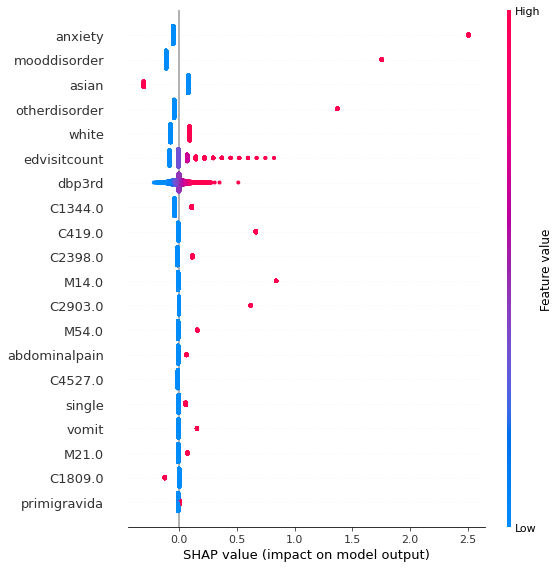

In [20]:
shap.summary_plot(shap_values, X_test2019)

In [36]:
data = pd.DataFrame({"edvisitcount" : 0,
  "white" : 0,
  "asian" : 0,
  "single" : 0,
  "anxiety" : 0,
  "C419.0" : 0,
  "mooddisorder" : 0, 
  "C3030.0" : 0,
  "C2903.0" : 0,
  "M14.0" : 0,
  "C3473.0" : 0,
  "C2359.0" : 0,
  "C1387.0" : 0,
  "vomit" : 0,
  "C236.0" : 0,
  "C2214.0" : 0,
  "abdominalpain" : 0,
  "C3059.0" : 0,
  "M39.0" : 0,
  "M21.0" : 0,
  "C2398.0" : 0,
  "C3626.0" : 0,
  "M54.0" : 0,
  "dbp3rd" : 0,
  "C3725.0" : 0,
  "C83.0" : 0,
  "M88.0" : 0,
  "C4527.0" : 0,
  "primigravida" : 0,
  "C1344.0" : 0,
  "C1809.0" : 0,
  "otherdisorder" : 0}, index = [0])

prediction = clfLogisticRegression.predict(data)
print(prediction[0])


0.0


In [40]:
clfLogisticRegression.coef_

array([[ 0.06033341,  0.16584786, -0.12467992,  0.09103602,  0.09718039,
         0.05430551,  0.67179572, -0.06164643,  0.84902264,  0.16567098,
         2.55742007,  1.86661628,  1.41370381,  0.08621278, -0.38581261,
         0.06025415,  0.14925696,  0.11536743,  0.07929952,  0.02610875,
         0.12803399,  0.61991324,  0.55167783,  0.01132975,  0.10938833,
         0.23181399,  0.07642398,  0.10084008, -0.01293   ,  0.07230297,
         0.01278604,  0.16003062]])

In [22]:
import requests
import json
import pandas as pd

#url = 'http://157.139.115.108:12345/predict'
#url = 'http://172.20.7.255:8080/predict'
url = 'http://127.0.0.1:12345/predict'

data = {"patient_id" :0,
    "edvisitcount" : 0,
  "white" : 0,
  "asian" : 0,
  "single" : 0,
  "anxiety" : 0,
  "C419.0" : 0,
  "mooddisorder" : 0, 
  "C3030.0" : 0,
  "C2903.0" : 0,
  "M14.0" : 0,
  "C3473.0" : 0,
  "C2359.0" : 0,
  "C1387.0" : 0,
  "vomit" : 0,
  "C236.0" : 0,
  "C2214.0" : 0,
  "abdominalpain" : 0,
  "C3059.0" : 0,
  "M39.0" : 0,
  "M21.0" : 0,
  "C2398.0" : 0,
  "C3626.0" : 0,
  "M54.0" : 0,
  "dbp3rd" : 0,
  "C3725.0" : 0,
  "C83.0" : 0,
  "M88.0" : 0,
  "C4527.0" : 0,
  "primigravida" : 0,
  "C1344.0" : 0,
  "C1809.0" : 0,
  "otherdisorder" : 0}
query_df = pd.DataFrame(data, index = [0])
query = query_df.drop(columns = ['patient_id'])
#headers = {'content-type': 'application/json'}
#r = requests.post(url, data=data, headers=headers)
#print(r)

In [99]:
import pickle
fh = open('explainer.pickle', 'rb')
explainer = pickle.load(fh)
explainer

In [100]:
shap_values = explainer.shap_values(query)

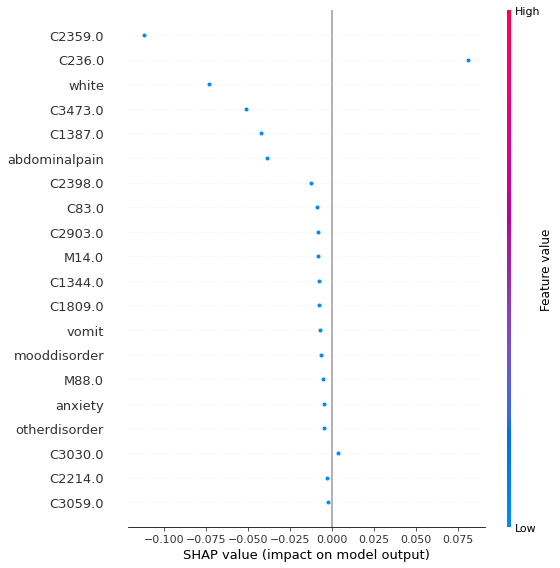

In [101]:
import shap
shap.summary_plot(shap_values, query)